In [1]:
import numpy as np
from scipy.stats import unitary_group
from scipy.special import binom
from opt_einsum import contract
from functools import partial
from itertools import product

from QTM_jax import QTM, HaarSampleGeneration
from distance_jax import sinkhornDistance, avgStateSupFid
from training_funcs import Training_t, TrainingAvgState_t
from moments import haarEnsembleMMT, rhoMMT, framePot, pauliTwirl_K2, pauliTwirlEnsemble, mmtDist_p

import jax
import jax.numpy as jnp

import qutip as qt

import time
import os

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=25)
rc('axes', linewidth=3)
rc('text.latex', preamble=r'\usepackage{amsfonts}')

Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module


In [101]:
def find_divisors(n):
    divisors = set()  # Using a set to avoid duplicates
    for i in range(1, int(np.sqrt(n)) + 1):
        if n % i == 0:
            divisors.add(i)
            divisors.add(n // i)
    return sorted(divisors)  # Return a sorted list of divisors

# QML training

In [ ]:
# average state training (linear interpolation)
n = 2
na = 1
L = n + na

T = 32
taus = np.arange(1, T+1)/T

Ndata = 400
epochs = 4001

# path = f'data/training/avgState/n{n}/record/'
# if not os.path.exists(path):
#     os.makedirs(path)

inputs_0 = np.zeros((Ndata, 2**n), dtype=np.complex64)
inputs_0[:, 0] = 1.
psi0 = np.zeros(2**n, dtype=np.complex64)
psi0[0] = 1.
sigmaT = np.eye(2**n, dtype=np.complex64)/2**n

model = QTM(n, na, T, L)
for t in range(T):
    params_tot = np.zeros((T, 2*(n + na)*L))
    for tt in range(t):
        params = np.load(os.path.join(path, f'HaarAvgparamshist_n{n}na{na}T{T}L{L}_t{tt}.npy'))
        params_tot[tt] = params[-1]
    params_tot = jnp.array(params_tot)

    params_hist, loss_hist, states_hist = TrainingAvgState_t(model, t, taus[t], inputs_0, psi0, sigmaT, params_tot, epochs)

    # np.save(os.path.join(path, f'HaarAvgparamshist_n{n}na{na}T{T}L{L}_t{t}.npy'), params_hist)
    # np.save(os.path.join(path, f'HaarAvglosshist_n{n}na{na}T{T}L{L}_t{t}.npy'), loss_hist)
    # np.save(os.path.join(path, f'HaarAvgstateshist_n{n}na{na}T{T}L{L}_t{t}.npy'), states_hist)
    # print(f'Step {t} complete, tau={taus[t]:.5f}')

In [ ]:
# training (exponential interpolation - fix t/T for tau(t, T)=const)
n = 2
na = 1
L = n + na

Ts = [2] + list(range(4, 34, 4))
rs = [3.44, 1.72, 0.86, 0.57, 0.43, 0.34, 0.29, 0.25, 0.22]

T_idx = 8
T = Ts[T_idx]
r = rs[T_idx]
taus = (1 - np.exp(-r*np.arange(1, T+1)))/(1 - np.exp(-r*T))

Ndata = 400
epochs = 5001

path = f'data/training/avgState/n{n}/record/'
if not os.path.exists(path):
    os.makedirs(path)

inputs_0 = np.zeros((Ndata, 2**n), dtype=complex)
inputs_0[:, 0] = 1.
psi0 = np.zeros(2**n, dtype=np.complex64)
psi0[0] = 1.
sigmaT = np.eye(2**n, dtype=complex)/2**n

model = QTM(n, na, T, L)
for t in range(T):
    params_tot = np.zeros((T, 2*(n + na)*L))
    for tt in range(t):
        params = np.load(os.path.join(path, f'HaarAvgparamshist_n{n}na{na}T{T}L{L}_t{tt}_r{r}.npy'))
        params_tot[tt] = params[-1]
    params_tot = jnp.array(params_tot)

    params_hist, loss_hist, states_hist = TrainingAvgState_t(model, t, taus[t], inputs_0, psi0, sigmaT, params_tot, epochs)

    np.save(os.path.join(path, f'HaarAvgparamshist_n{n}na{na}T{T}L{L}_t{t}_r{r}.npy'), params_hist)
    np.save(os.path.join(path, f'HaarAvglosshist_n{n}na{na}T{T}L{L}_t{t}_r{r}.npy'), loss_hist)
    np.save(os.path.join(path, f'HaarAvgstateshist_n{n}na{na}T{T}L{L}_t{t}_r{r}.npy'), states_hist)
    print(f'Step {t} complete, tau={taus[t]:.5f}')

# States generation

# Result

## Pauli twirling ensemble

In [5]:
# stablizer state
ns = list(range(1, 6))

path = f'data/pauliTwirl'
if not os.path.exists(path):
    os.mkdir(path)
        
K = 4
fps_stab = np.zeros((2, len(ns)))
for i in range(5):
    psi0 = qt.tensor([qt.basis(2, 0)]*ns[i])
    ghz = qt.ghz_state(ns[i])
    states = pauliTwirlEnsemble(ns[i], psi0)
    fps_stab[0, i] = framePot(np.stack(states).squeeze(), K=K)
    states = pauliTwirlEnsemble(ns[i], ghz)
    fps_stab[1, i] = framePot(np.stack(states).squeeze(), K=K)
    
np.save(os.path.join(path, f'pauliTwStabFP_K{K}.npy'), fps_stab)

In [ ]:
# haar random state
ns = list(range(1, 6))

path = f'data/pauliTwirl'
if not os.path.exists(path):
    os.mkdir(path)
        
K = 4
fps = np.zeros(len(ns))
for i in range(5):
    psi0 = qt.rand_ket_haar(N=2**ns[i], dims=[[2]*ns[i], [1]*ns[i]], seed=42)
    states = pauliTwirlEnsemble(ns[i], psi0)
    fps[i] = framePot(np.stack(states).squeeze(), K=K)
    
np.save(os.path.join(path, f'pauliTwHaarFP_K{K}.npy'), fps)

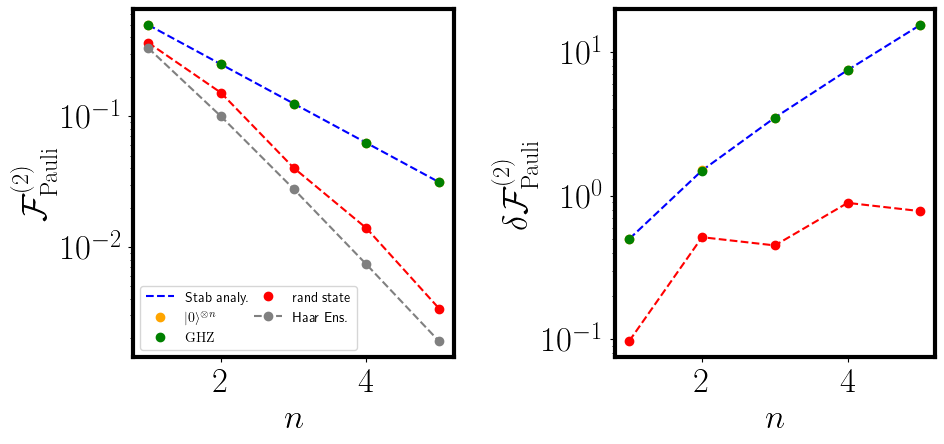

In [44]:
# 2nd frame potential
ns = np.arange(1, 6)
path = f'data/pauliTwirl'

K = 2
fps_stab = np.load(os.path.join(path, f'pauliTwStabFP_K{K}.npy'))
fps_rand = np.load(os.path.join(path, f'pauliTwHaarFP_K{K}.npy'))

paulis = [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]
fps_rand_anal = np.zeros(5)
for i in range(5):
    rand_ket = qt.rand_ket_haar(N=2**ns[i], dims=[[2]*ns[i], [1]*ns[i]], seed=42)
    Cs = np.ones(4**ns[i])
    for j, s in enumerate(product(range(4), repeat=ns[i])):
        if j:
            P = qt.tensor([paulis[x] for x in s])
            Cs[j] = qt.expect(P, rand_ket)
    fps_rand_anal[i] = np.sum(Cs**4)/4**ns[i]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(ns, 1/2.**ns, '--', label='Stab analy.', c='b')
axs[0].plot(ns, fps_stab[0], 'o', label=r'$|0\rangle^{\otimes n}$', c='orange')
axs[0].plot(ns, fps_stab[1], 'o', label=r'$\rm GHZ$', c='g')
axs[0].plot(ns, fps_rand, 'o', label='rand state', c='r')
axs[0].plot(ns, fps_rand_anal, '--', c='r')
axs[0].plot(ns, 1/binom(2**ns+K-1, K), 'o--', label='Haar Ens.', c='grey')
axs[0].legend(fontsize=10, ncol=2, columnspacing=0.4)
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$n$')
axs[0].set_ylabel(r'$\mathcal{F}_{\rm Pauli}^{(2)}$')

axs[1].plot(ns, (2**ns+1)*2**ns/(2*2**ns)-1, '--', c='b')
axs[1].plot(ns, fps_stab[0]*binom(2**np.arange(1, 6)+K-1, K) - 1, 'o', c='orange')
axs[1].plot(ns, fps_stab[1]*binom(2**np.arange(1, 6)+K-1, K) - 1, 'o', c='g')
axs[1].plot(ns, fps_rand*binom(2**np.arange(1, 6)+K-1, K) - 1, 'o', c='r')
axs[1].plot(ns, fps_rand_anal*binom(2**np.arange(1, 6)+K-1, K) - 1, '--', c='r')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$n$')
axs[1].set_ylabel(r'$\delta \mathcal{F}_{\rm Pauli}^{(2)}$')

plt.tight_layout()

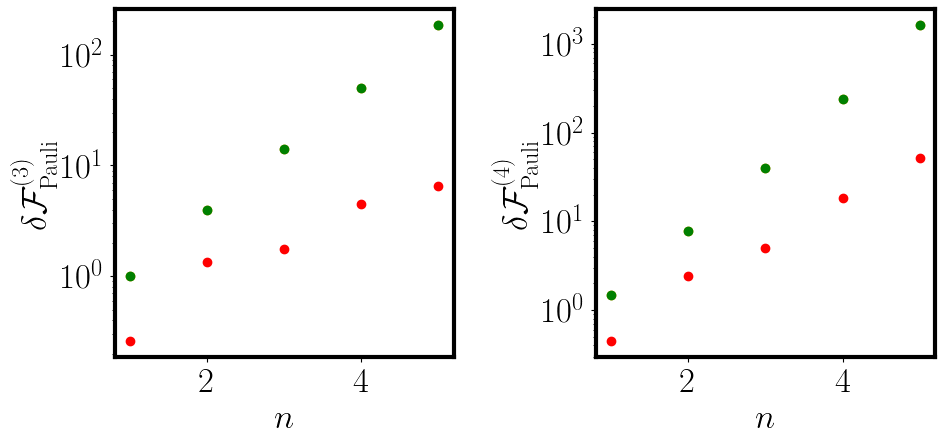

In [16]:
# higher frame potential
ns = np.arange(1, 6)
path = 'data/pauliTwirl'

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for K in [3, 4]:
    fps_stab = np.load(os.path.join(path, f'pauliTwStabFP_K{K}.npy'))
    fps_rand = np.load(os.path.join(path, f'pauliTwHaarFP_K{K}.npy'))
    
    fp_haar = 1./binom(2**ns+K-1, K)
    axs[K-3].plot(ns, fps_stab[0]/fp_haar - 1, 'o', label=r'$|0\rangle^{\otimes n}$', c='orange')
    axs[K-3].plot(ns, fps_stab[1]/fp_haar - 1, 'o', label=r'$\rm GHZ$', c='g')
    axs[K-3].plot(ns, fps_rand/fp_haar - 1, 'o', label='rand state', c='r')
    axs[K-3].set_yscale('log')
    axs[K-3].set_xlabel(r'$n$')
    axs[K-3].set_ylabel(r'$\delta \mathcal{F}_{\rm Pauli}^{(%d)}$'%K)
plt.tight_layout()

## QTM result

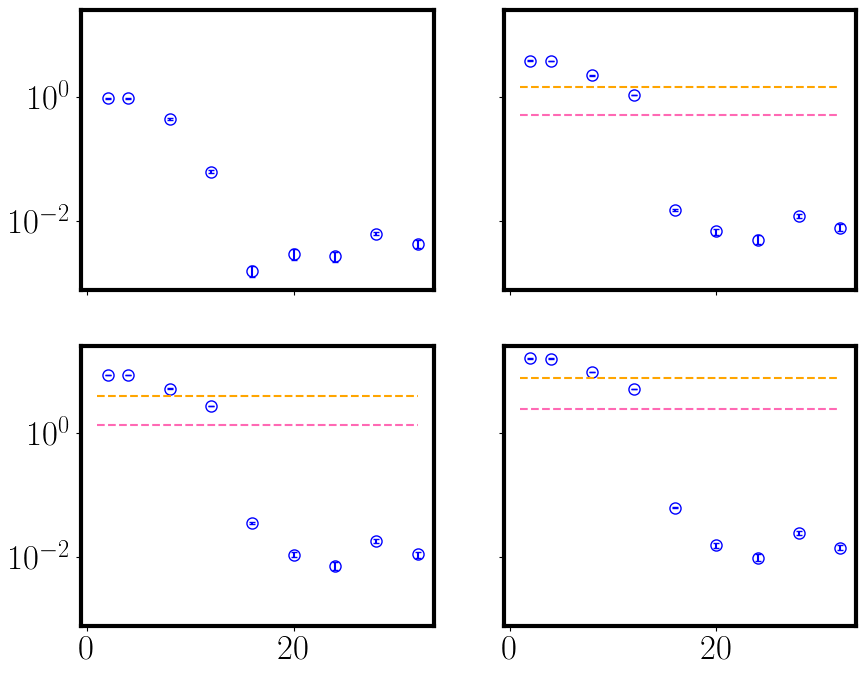

In [25]:
n = 2
Ks = [1, 2, 3, 4]
Ts = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
Ndata = int(1e4)

fps_avg = np.zeros((len(Ks), 10, len(Ts)-1))
for i in range(4):
    each = np.load(f'data/zero2haar/n{n}/mmts/HaarAvgFPK{Ks[i]}_n{n}na1L3_exp.npy')
    for j in range(len(Ts)-1):
        fps_avg[i, :, j] = each[j, :, Ts[j+1]]

fps_pauli = np.zeros((2, 4))
fps_pauli[0] = [0, 0.25, 0.24967974, 0.24957308]
fps_pauli[1] = [0, 0.15134782, 0.11726889, 0.0982407]

fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
for i in range(4):
    fp_h = 1/binom(2**n + Ks[i]-1, Ks[i])
    axs[i//2, i%2].errorbar(Ts[1:], np.mean(fps_avg[i]-fp_h, axis=0)/fp_h, 
        yerr=np.std(fps_avg[i]-fp_h, axis=0)/fp_h, fmt='o', mfc='white', markersize=8, 
        barsabove=True, capsize=2, c='b', label='QuTM (avg state)')
    axs[i//2, i%2].hlines((fps_pauli[0, i]-fp_h)/fp_h, xmin=1, xmax=32, ls='--', color='orange')
    axs[i//2, i%2].hlines((fps_pauli[1, i]-fp_h)/fp_h, xmin=1, xmax=32, ls='--', color='hotpink')
axs[0, 0].set_yscale('log')

# Generate states of two schemes

## compare interpolation method

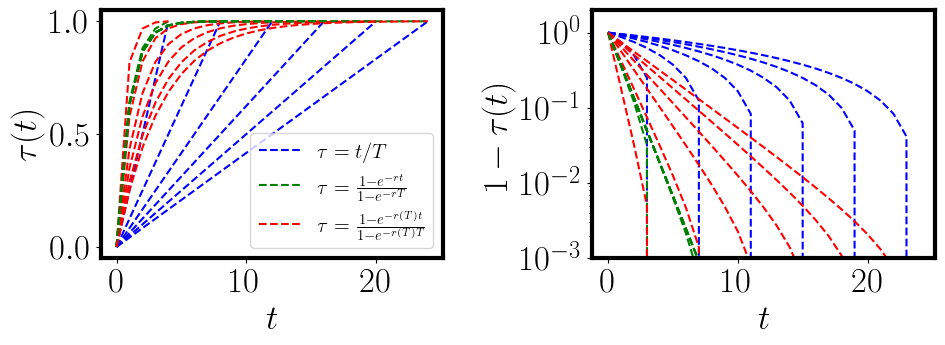

In [7]:
Ts = list(range(4, 26, 4))
r = 1
rs2 = [1.7, 0.86, 0.57, 0.43, 0.34, 0.29]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for i in range(len(Ts)):
    T = Ts[i]
    tau_lin = np.arange(T+1)/T
    tau_exp1 = (1 - np.exp(-r*np.arange(T+1)))/(1 - np.exp(-r*T))
    tau_exp2 = (1 - np.exp(-rs2[i]*np.arange(T+1)))/(1 - np.exp(-rs2[i]*T))
    axs[0].plot(np.arange(T+1), tau_lin, '--', c='b')
    axs[0].plot(np.arange(T+1), tau_exp1, '--', c='g')
    axs[0].plot(np.arange(T+1), tau_exp2, '--', c='r')

    axs[1].plot(np.arange(T+1), 1-tau_lin, '--', c='b')
    axs[1].plot(np.arange(T+1), 1-tau_exp1, '--', c='g')
    axs[1].plot(np.arange(T+1), 1-tau_exp2, '--', c='r')

axs[0].legend([r'$\tau=t/T$', r'$\tau = \frac{1-e^{-r t}}{1-e^{-r T}}$', r'$\tau = \frac{1-e^{-r(T) t}}{1-e^{-r(T) T}}$'], fontsize=15)
axs[0].set_ylabel(r'$\tau(t)$')
axs[0].set_xlabel(r'$t$')

axs[1].set_ylabel(r'$1-\tau(t)$')
axs[1].set_xlabel(r'$t$')
axs[1].set_yscale('log')
axs[1].set_ylim(1e-3, 2)
plt.tight_layout()

plt.savefig('figures/tau.pdf', bbox_inches='tight')
plt.show()
plt.close()

## training scheme

In [ ]:
# training (linear interpolation)
n = 2
na = 1
L = n + na

T = 16
taus = np.arange(1, T+1)/T # linear interpolation

Ndata = 256
epochs = 5001

path = f'data/QWIT/zero2haar/n{n}/record/'
if not os.path.exists(path):
    os.makedirs(path)

inputs_0 = np.zeros((Ndata, 2**n), dtype=complex)
inputs_0[:, 0] = 1.
X0 = np.zeros((Ndata*10, 2**n), dtype=complex)
X0[:, 0] = 1.
XT = HaarSampleGeneration(Ndata*10, n, seed=12)

model = QTM(n, na, T, L)
for t in range(T):
    params_tot = np.zeros((T, 2*(n + na)*L))
    for tt in range(t):
        params = np.load(os.path.join(path, f'QTMparamshist_n{n}na{na}T{T}L{L}_t{tt}_lin.npy'))
        params_tot[tt] = params[-1]
    params_tot = jnp.array(params_tot)

    params_hist, loss_hist = Training_t(model, t, taus[t], inputs_0, X0, XT, params_tot, epochs, dis_measure='sd')

    np.save(os.path.join(path, f'QTMparamshist_n{n}na{na}T{T}L{L}_t{t}_lin.npy'), params_hist)
    np.save(os.path.join(path, f'QTMlosshist_n{n}na{na}T{T}L{L}_t{t}_lin.npy'), loss_hist)
    print(f'Step {t} complete, tau={taus[t]}')

In [ ]:
# training (exponential interpolation - fix t/T for tau(t, T)=const)
n = 2
na = 1
L = n + na

Ts = [2] + list(range(4, 26, 4))
rs = [3.44, 1.72, 0.86, 0.57, 0.43, 0.34, 0.29]

T_idx = 4
T = Ts[T_idx]
r = rs[T_idx]
taus = (1 - np.exp(-r*np.arange(1, T+1)))/(1 - np.exp(-r*T))

Ndata = 256
epochs = 5001

path = f'data/QWIT/zero2haar/n{n}/record/'
if not os.path.exists(path):
    os.makedirs(path)

inputs_0 = np.zeros((Ndata, 2**n), dtype=complex)
inputs_0[:, 0] = 1.
X0 = np.zeros((Ndata*10, 2**n), dtype=complex)
X0[:, 0] = 1.
XT = HaarSampleGeneration(Ndata*10, n, seed=12)

model = QTM(n, na, T, L)
for t in range(T):
    params_tot = np.zeros((T, 2*(n + na)*L))
    for tt in range(t):
        params = np.load(os.path.join(path, f'QTMparamshist_n{n}na{na}T{T}L{L}_t{tt}_r{r}.npy'))
        params_tot[tt] = params[-1]
    params_tot = jnp.array(params_tot)

    params_hist, loss_hist = Training_t(model, t, taus[t], inputs_0, X0, XT, params_tot, epochs, dis_measure='sd')

    np.save(os.path.join(path, f'QTMparamshist_n{n}na{na}T{T}L{L}_t{t}_r{r}.npy'), params_hist)
    np.save(os.path.join(path, f'QTMlosshist_n{n}na{na}T{T}L{L}_t{t}_r{r}.npy'), loss_hist)
    print(f'Step {t} complete, tau={taus[t]}')

In [10]:
# generate data (linear)
n = 2
na = 1
L = n + na
Ndata = int(1e4)

inputs_0 = np.zeros((Ndata, 2**n), dtype=complex)
inputs_0[:, 0] = 1.

T = 24

path = f'data/QWIT/zero2haar/n{n}'
params_tot = np.load(os.path.join(path, f'params/QTMparams_n{n}na{na}T{T}L{L}_lin.npy'))

model = QTM(n, na, T, L)

states = []
for k in range(10):
    states.append(model.dataGeneration(inputs_0, params_tot))
np.save(os.path.join(path, f'states/QTMstates_n{n}na{na}T{T}L{L}_lin.npy'), np.stack(states, axis=1))

In [2]:
# generate data (exponential)
n = 2
na = 1
L = n + na
Ndata = int(1e4)

inputs_0 = np.zeros((Ndata, 2**n), dtype=complex)
inputs_0[:, 0] = 1.

# exponential
Ts = [2] + list(range(4, 34, 4))
rs = [3.44, 1.72, 0.86, 0.57, 0.43, 0.34, 0.29, 0.25, 0.22]

Tidx = 6
T = Ts[Tidx]
r = rs[Tidx]
#r = 1

path = f'data/QWIT/zero2haar/n{n}'
params_tot = np.load(os.path.join(path, f'params/QTMparams_n{n}na{na}T{T}L{L}_r{r}_N512.npy'))

model = QTM(n, na, T, L)

states = []
for k in range(10):
    states.append(model.dataGeneration(inputs_0, params_tot))
np.save(os.path.join(path, f'states/QTMstates_n{n}na{na}T{T}L{L}_r{r}_N512.npy'), np.stack(states, axis=1))

In [24]:
# generate data (exponential & average state training)
n = 2
na = 1
L = n + na
Ndata = int(1e4)

inputs_0 = np.zeros((Ndata, 2**n), dtype=complex)
inputs_0[:, 0] = 1.

# exponential
Ts = [2] + list(range(4, 34, 4))
rs = [3.44, 1.72, 0.86, 0.57, 0.43, 0.34, 0.29, 0.25, 0.22]

Tidx = 8
T = Ts[Tidx]
r = rs[Tidx]
#r = 1

path = f'data/QWIT/zero2haar/n{n}'
params_tot = np.load(os.path.join(path, f'params/HaarAvgparams_n{n}na{na}T{T}L{L}_r{r}.npy'))

model = QTM(n, na, T, L)

states = []
for k in range(10):
    states.append(model.dataGeneration(inputs_0, params_tot))
np.save(os.path.join(path, f'states/HaarAvgstates_n{n}na{na}T{T}L{L}_r{r}.npy'), np.stack(states, axis=1))

In [ ]:
# moments and frame potential calcualation (linear)
n, na = 2, 1
L = n + na

Ts = [2] + list(range(4, 25, 4))

K = 4
rho_haar_K = haarEnsembleMMT(n, K)

rho_moment_jit = jax.jit(partial(rhoMMT, probs=None, K=K))
traceDist_jit = jax.jit(partial(traceDist, rho2=rho_haar_K))

path = f'data/QWIT/zero2haar/n{n}'
mmt_dists = np.zeros((len(Ts), 10, max(Ts) + 1))
fps = np.zeros((len(Ts), 10, max(Ts) + 1))
for i in range(len(Ts)):
    states = np.load(os.path.join(path, f'states/QTMstates_n{n}na{na}T{Ts[i]}L{L}_lin.npy'))
    t1 = time.time()
    for k in range(10):
        for t in range(Ts[i] + 1):
            rho_t = rho_moment_jit(states[t, k])
            mmt_dists[i, k, t] = traceDist_jit(rho_t)
            fps[i, k, t] = np.trace(rho_t @ rho_t)
    print(f'K={K}, T={Ts[i]}, time={time.time()-t1}')
np.save(os.path.join(path, f'mmts/QTMMMTdistK{K}_n{n}na{na}L{L}_lin.npy'), mmt_dists)
np.save(os.path.join(path, f'mmts/QTMFPK{K}_n{n}na{na}L{L}_lin.npy'), fps)

In [ ]:
# moments calcualation (exp fix ratio)
n, na = 2, 1
L = n + na

Ts = [2] + list(range(4, 34, 4))
rs = [3.44, 1.72, 0.86, 0.57, 0.43, 0.34, 0.29, 0.25, 0.22]

K = 1
rho_haar_K = haarEnsembleMMT(n, K)

rho_moment_jit = jax.jit(partial(rhoMMT, probs=None, K=K))
traceDist_jit = jax.jit(partial(traceDist, rho2=rho_haar_K))

path = f'data/QWIT/zero2haar/n{n}'
mmt_dists = np.zeros((len(Ts), 10, max(Ts) + 1))
fps = np.zeros((len(Ts), 10, max(Ts) + 1))
for i in range(len(Ts)):
    states = np.load(os.path.join(path, f'states/QTMstates_n{n}na{na}T{Ts[i]}L{L}_r{rs[i]}.npy'))
    t1 = time.time()
    for k in range(10):
        for t in range(Ts[i] + 1):
            rho_t = rho_moment_jit(states[t, k])
            mmt_dists[i, k, t] = traceDist_jit(rho_t)
            fps[i, k, t] = np.trace(rho_t @ rho_t)
    print(f'K={K}, T={Ts[i]}, time={time.time()-t1}')
np.save(os.path.join(path, f'mmts/QTMMMTdistK{K}_n{n}na{na}L{L}_exp.npy'), mmt_dists)
np.save(os.path.join(path, f'mmts/QTMFPK{K}_n{n}na{na}L{L}_exp.npy'), fps)

In [ ]:
# moments and frame potential calcualation (exponential & average state training)
n, na = 2, 1
L = n + na

Ts = [2] + list(range(4, 24, 4))
rs = [3.44, 1.72, 0.86, 0.57, 0.43, 0.34]

K = 4
rho_haar_K = haarEnsembleMMT(n, K)

rho_moment_jit = jax.jit(partial(rhoMMT, probs=None, K=K))
traceDist_jit = jax.jit(partial(traceDist, rho2=rho_haar_K))

path = f'data/QWIT/zero2haar/n{n}'
mmt_dists = np.zeros((len(Ts), 10, max(Ts) + 1))
fps = np.zeros((len(Ts), 10, max(Ts) + 1))
for i in range(len(Ts)):
    states = np.load(os.path.join(path, f'states/HaarAvgstates_n{n}na{na}T{Ts[i]}L{L}_r{rs[i]}.npy'))
    t1 = time.time()
    for k in range(10):
        for t in range(Ts[i] + 1):
            rho_t = rho_moment_jit(states[t, k])
            mmt_dists[i, k, t] = traceDist_jit(rho_t)
            fps[i, k, t] = np.trace(rho_t @ rho_t)
    print(f'K={K}, T={Ts[i]}, time={time.time()-t1}')
np.save(os.path.join(path, f'mmts/HaarAvgMMTdistK{K}_n{n}na{na}L{L}_exp.npy'), mmt_dists)
np.save(os.path.join(path, f'mmts/HaarAvgFPK{K}_n{n}na{na}L{L}_exp.npy'), fps)

## haar random

In [207]:
n = 2
Nlist = 2**np.arange(2, 15)

K = 1
rho_haar_K = haarEnsembleMMT(n, K)

rho_moment_jit = jax.jit(partial(rho_moment, K=K))
traceDist_jit = jax.jit(partial(traceDist, rho2=rho_haar_K))

path = f'data/QWIT/zero2haar/haar'
mmt_dists = np.zeros((len(Nlist), 10))
fps = np.zeros((len(Nlist), 10))
for cc, Ndata in enumerate(Nlist):
    t1 = time.time()
    for k in range(10):
        states = HaarSampleGeneration(Ndata, n, seed=42+k)
        rho_t = rho_moment_jit(states)
        mmt_dists[cc, k] = traceDist_jit(rho_t)
        fps[cc, k] = np.trace(rho_t @ rho_t)
    print(f'K={K}, N={Ndata}, time={time.time()-t1}')
np.save(os.path.join(path, f'MMTdistK{K}_n{n}.npy'), mmt_dists)
np.save(os.path.join(path, f'FPK{K}_n{n}.npy'), fps)

C:\Users\Bingzhi\AppData\Local\Temp\ipykernel_34120\3218811522.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  fps[cc, k] = np.trace(rho_t @ rho_t)


K=1, N=4, time=0.1411607265472412
K=1, N=8, time=0.06301331520080566
K=1, N=16, time=0.05546998977661133
K=1, N=32, time=0.0632619857788086
K=1, N=64, time=0.07836508750915527
K=1, N=128, time=0.11126470565795898
K=1, N=256, time=0.09317135810852051
K=1, N=512, time=0.10332822799682617
K=1, N=1024, time=0.11055707931518555
K=1, N=2048, time=0.16059613227844238
K=1, N=4096, time=0.271742582321167
K=1, N=8192, time=0.46954989433288574
K=1, N=16384, time=0.7989933490753174


## haar sequential

### global

In [10]:
# global haar circuit
n = 2
na = 5
T = 24

Ndata = int(1e4)

hsm = haarSeqModel(n, na, T)

path = f'data/QWIT/zero2haar/SRUC/gSRUC'
if not os.path.exists(path):
    os.makedirs(path)

states = []
for k in range(10):
    t1 = time.time()
    np.random.seed(42+k)
    Us = unitary_group.rvs(dim=2**(n+na), size=T)
    hsm.setUnitary(Us)
    states.append(hsm.dataGeneration_global(Ndata))
    print(f'repetition{k+1}, time={time.time()-t1}')
np.save(os.path.join(path, f'gSRUCstates_n{n}na{na}T{T}.npy'), np.stack(states))

repetition1, time=2.833961248397827
repetition2, time=2.176311731338501
repetition3, time=2.20552921295166
repetition4, time=2.1719698905944824
repetition5, time=2.2139739990234375
repetition6, time=2.169508934020996
repetition7, time=2.235504150390625
repetition8, time=2.211501359939575
repetition9, time=2.264711856842041
repetition10, time=2.246236801147461


In [ ]:
# moments & frame potential calculation (global)
n = 2
nas = np.arange(1, 10)
T = 24

K = 1
rho_haar_K = haarEnsembleMMT(n, K)

rho_moment_jit = jax.jit(partial(rho_moment, K=K))
traceDist_jit = jax.jit(partial(traceDist, rho2=rho_haar_K))

path = f'data/QWIT/zero2haar/SRUC/gSRUC'
mmt_dist = np.zeros((len(nas), 10, T+1))
fps = np.zeros((len(nas), 10, T+1))
for i in range(len(nas)):
    t1 = time.time()
    states = jnp.load(os.path.join(path, f'gSRUCstates_n{n}na{nas[i]}T{T}.npy'))
    for k in range(10):
        for t in range(T+1):
            rho_t = rho_moment_jit(states[k, t])
            mmt_dist[i, k, t] = traceDist_jit(rho_t)
            fps[i, k, t] = np.trace(rho_t @ rho_t)
    print(f'na={nas[i]}, time={time.time()-t1}')
np.save(os.path.join(path, f'gSRUCMMTdistK{K}_n{n}T{T}.npy'), mmt_dist)
np.save(os.path.join(path, f'gSRUCFPK{K}_n{n}T{T}.npy'), fps)

### local

In [ ]:
# local circuit with same number of 2-qubit gates
# fix number of ancilla
n = 2
na = 1
T_tr = 20
# total number CZ gate in QTM
Ngates = T_tr * (n + na) * (n + na - 1)
print(Ngates)

Ts = find_divisors(Ngates//(n + na - 1))
print(Ts)
Ndata = int(1e4)
path = f'data/QWIT/zero2haar/SRUC/lSRUC'

states = np.zeros((len(Ts), 10, Ndata, 2**n), dtype=complex)
for i in range(len(Ts)):
    L = Ngates// (Ts[i] * (n + na - 1))
    model = haarSeqModel(n, na, Ts[i], L=L)
    t1 = time.time()
    for k in range(10):
        Us = localUs(n + na, Ts[i], L, seed=42+k)
        model.setUnitary(Us)
        states[i, k] = model.dataGeneration_local(Ndata)[-1]
    print(f'T={Ts[i]}, L={L}, time={time.time() - t1}')
np.save(os.path.join(path, f'lSRUCstates_n{n}na{na}G{Ngates}.npy'), states)

In [ ]:
# local circuit with same number of T
# fix number of ancilla
n = 2
na = 1
T_tr = 20

Ls = [1, 2, 3, 4, 8, 16, 32]
Ndata = int(1e4)
path = f'data/QWIT/zero2haar/SRUC/n{n}'

states = np.zeros((len(Ls), 10, Ndata, 2**n), dtype=complex)
for i in range(len(Ls)):
    model = haarSeqModel(n, na, T_tr, L=Ls[i])
    t1 = time.time()
    for k in range(10):
        Us = localUs(n + na, T_tr, Ls[i], seed=42+k)
        model.setUnitary(Us)
        states[i, k] = model.dataGeneration_local(Ndata)[-1]
    print(f'T={T_tr}, L={Ls[i]}, time={time.time() - t1}')
np.save(os.path.join(path, f'lSRUCstates_n{n}na{na}T{T_tr}.npy'), states)

In [54]:
# local circuit with same number of L
# fix number of ancilla
n = 2
na = 1
L = n + na

Ts = [1, 2, 4, 8, 12, 16, 20]
Ndata = int(1e4)
path = f'data/QWIT/zero2haar/SRUC/n{n}'

states = np.zeros((len(Ts), 10, Ndata, 2**n), dtype=complex)
for i in range(len(Ts)):
    model = haarSeqModel(n, na, Ts[i], L=L)
    t1 = time.time()
    for k in range(10):
        Us = localUs(n + na, Ts[i], L, seed=42+k)
        model.setUnitary(Us)
        states[i, k] = model.dataGeneration_local(Ndata)[-1]
    print(f'T={Ts[i]}, L={L}, time={time.time() - t1}')
np.save(os.path.join(path, f'lSRUCstates_n{n}na{na}L{L}.npy'), states)

T=1, L=1, time=0.5054152011871338
T=2, L=2, time=0.5384371280670166
T=4, L=3, time=0.6641695499420166
T=8, L=4, time=0.8438880443572998
T=12, L=8, time=1.0486009120941162
T=16, L=16, time=1.3036127090454102
T=20, L=32, time=1.4811060428619385


In [79]:
# local circuit with same number of L
# fix number of ancilla
n = 2
na = 1
L = n + na
T = 24
Ndata = int(1e4)
path = f'data/QWIT/zero2haar/SRUC/n{n}'

states = np.zeros((T+1, 10, Ndata, 2**n), dtype=complex)
model = haarSeqModel(n, na, T, L=L)
t1 = time.time()
for k in range(10):
    Us = localUs(n + na, T, L, seed=42+k)
    model.setUnitary(Us)
    states[:, k] = model.dataGeneration_local(Ndata)
print(f'T={T}, L={L}, time={time.time() - t1}')
np.save(os.path.join(path, f'lSRUCstates_n{n}na{na}T{T}L{L}.npy'), states)

T=24, L=3, time=1.9118013381958008


In [ ]:
# moments calculation (local circuit with same number of 2-qubit gates)
# fix number of ancilla
n = 2
na = 1
T_tr = 20
Ngates = T_tr * (n + na) * (n + na - 1)

Ts = [1, 2, 3, 4, 5, 6, 10, 12, 15, 20, 30, 60]

K = 4
rho_haar_K = haarEnsembleMMT(n, K)
rho_moment_jit = jax.jit(partial(rho_moment, K = K))
traceDist_jit = jax.jit(partial(traceDist, rho2 = rho_haar_K))

path = f'data/QWIT/zero2haar/SRUC/n{n}'
states = np.load(os.path.join(path, f'lSRUCstates_n{n}na{na}G{Ngates}.npy'))
mmt_dist = np.zeros((len(Ts), 10))
fps = np.zeros((len(Ts), 10))
for i in range(len(Ts)):
    t1 = time.time()
    for k in range(10):
        rho_t = rho_moment_jit(states[i, k])
        mmt_dist[i, k] = np.array(traceDist_jit(rho_t))
        fps[i, k] = np.trace(rho_t @ rho_t)
    print(f'K={K}, T={Ts[i]}, time={time.time() - t1} seconds')
np.save(os.path.join(path, f'lSRUCMMTdistK{K}_n{n}na{na}G{Ngates}.npy'), mmt_dist)
np.save(os.path.join(path, f'lSRUCFPK{K}_n{n}na{na}G{Ngates}.npy'), fps)

In [173]:
# moments calculation (local circuit with same T)
# fix number of ancilla
n = 2
na = 1
T_tr = 20

Ls = [1, 2, 3, 4, 8, 16, 32]

K = 4
rho_haar_K = haarEnsembleMMT(n, K)
rho_moment_jit = jax.jit(partial(rho_moment, K = K))
traceDist_jit = jax.jit(partial(traceDist, rho2 = rho_haar_K))

path = f'data/QWIT/zero2haar/SRUC/n{n}'
states = np.load(os.path.join(path, f'lSRUCstates_n{n}na{na}T{T_tr}.npy'))
mmt_dist = np.zeros((len(Ls), 10))
fps = np.zeros((len(Ls), 10))
for i in range(len(Ls)):
    t1 = time.time()
    for k in range(10):
        rho_t = rho_moment_jit(states[i, k])
        mmt_dist[i, k] = np.array(traceDist_jit(rho_t))
        fps[i, k] = np.trace(rho_t @ rho_t)
    print(f'K={K}, L={Ls[i]}, time={time.time() - t1} seconds')
np.save(os.path.join(path, f'lSRUCMMTdistK{K}_n{n}na{na}T{T_tr}.npy'), mmt_dist)
np.save(os.path.join(path, f'lSRUCFPK{K}_n{n}na{na}T{T_tr}.npy'), fps)

C:\Users\Bingzhi\AppData\Local\Temp\ipykernel_34120\3913635016.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  fps[i, k] = np.trace(rho_t @ rho_t)


K=4, L=1, time=21.299254655838013 seconds
K=4, L=2, time=19.018534421920776 seconds
K=4, L=3, time=19.00937271118164 seconds
K=4, L=4, time=19.145387411117554 seconds
K=4, L=8, time=19.75637912750244 seconds
K=4, L=16, time=18.993504285812378 seconds
K=4, L=32, time=19.66636061668396 seconds


In [85]:
# moments calculation (local circuit with same L)
# fix number of ancilla
n = 2
na = 1
L = n + na

K = 4
rho_haar_K = haarEnsembleMMT(n, K)
rho_moment_jit = jax.jit(partial(rho_moment, K = K))
traceDist_jit = jax.jit(partial(traceDist, rho2 = rho_haar_K))

path = f'data/QWIT/zero2haar/SRUC/n{n}'
states = np.load(os.path.join(path, f'lSRUCstates_n{n}na{na}L{L}.npy'))
mmt_dist = np.zeros((len(Ts), 10))
fps = np.zeros((len(Ts), 10))
for i in range(len(Ts)):
    t1 = time.time()
    for k in range(10):
        rho_t = rho_moment_jit(states[i, k])
        mmt_dist[i, k] = np.array(traceDist_jit(rho_t))
        fps[i, k] = np.trace(rho_t @ rho_t)
    print(f'K={K}, T={Ts[i]}, time={time.time() - t1} seconds')
np.save(os.path.join(path, f'lSRUCMMTdistK{K}_n{n}na{na}L{L}.npy'), mmt_dist)
np.save(os.path.join(path, f'lSRUCFPK{K}_n{n}na{na}L{L}.npy'), fps)

C:\Users\Bingzhi\AppData\Local\Temp\ipykernel_28820\951762774.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  fps[i, k] = np.trace(rho_t @ rho_t)


K=4, T=1, time=30.279375076293945 seconds
K=4, T=2, time=19.693589210510254 seconds
K=4, T=4, time=20.108898162841797 seconds
K=4, T=8, time=19.736450910568237 seconds
K=4, T=12, time=18.48960542678833 seconds
K=4, T=16, time=19.087421655654907 seconds
K=4, T=20, time=17.877219676971436 seconds


# 1 qubit result

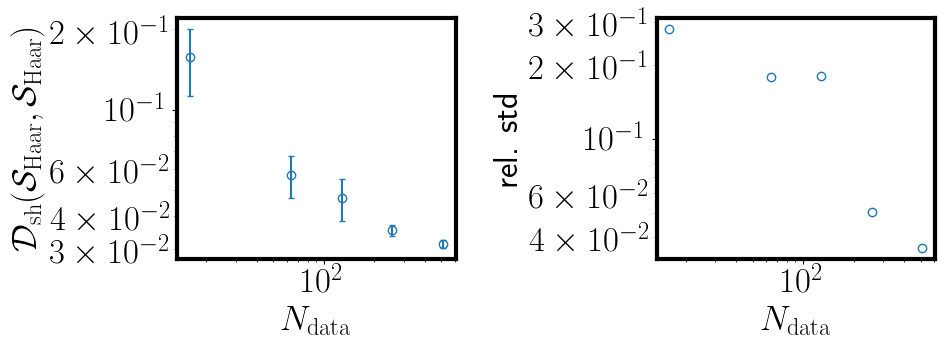

In [3]:
# scaling of sinkhorn distance
n = 1
Ns = [16, 64, 128, 256, 512]
ds = np.zeros((len(Ns), 10))
for i in range(len(Ns)):
    for k in range(10):
        ds[i, k] = sinkhornDistance(HaarSampleGeneration(Ns[i], n, seed=12), 
                    HaarSampleGeneration(Ns[i], n, seed = 20 + k), reg=0.005)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].errorbar(Ns, np.mean(ds, axis=1), yerr=np.std(ds, axis=1), fmt='o', mfc='white', 
                barsabove=True, capsize=2)
axs[0].set_ylabel(r'$\mathcal{D}_{\rm sh}(\mathcal{S}_{\rm Haar}, \mathcal{S}_{\rm Haar})$')
axs[0].set_xlabel(r'$N_{\rm data}$')
axs[0].set_yscale('log')
axs[0].set_xscale('log')

axs[1].plot(Ns, np.std(ds, axis=1)/np.mean(ds, axis=1), 'o', mfc='white')
axs[1].set_ylabel('rel. std')
axs[1].set_xlabel(r'$N_{\rm data}$')
axs[1].set_yscale('log')
axs[1].set_xscale('log')

plt.tight_layout()

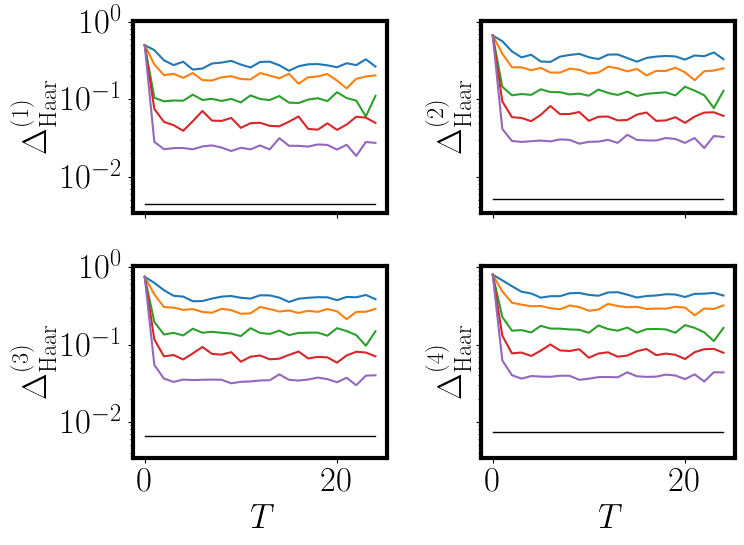

In [92]:
# global HSM
n = 1
nas_hsm = [1, 2, 4, 6, 8]
T = 24
Ndata = int(1e4)

Ks = [1, 2, 3, 4]
path = 'data/QWIT/zero2haar/'
mmt_dist_hsm = np.zeros((len(Ks), len(nas_hsm), 10, T+1))
for i in range(len(Ks)):
    mmt_dist_hsm[i] = np.load(os.path.join(path, f'haSeq/n{n}/haSeqGlMMTdistK{Ks[i]}_n{n}T{T}.npy'))

fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
for i in range(len(Ks)):
    axs[i//2, i%2].plot(np.mean(mmt_dist_hsm[i], axis=1).T)
    mmt_base = traceDist(rho_moment(HaarSampleGeneration(Ndata, n, seed=200), Ks[i]), 
                         haarEnsembleMMT(n, Ks[i]))
    axs[i//2, i%2].plot(mmt_base*np.ones(T+1), c='k', lw=1)
    axs[i//2, i%2].set_ylabel(fr'$\Delta_{{\rm Haar}}^{{({Ks[i]})}}$')
    axs[1, i%2].set_xlabel(r'$T$')
axs[0, 0].set_yscale('log')
plt.tight_layout()

c:\Users\Bingzhi\envs\tensorCircuit_tf\lib\site-packages\IPython\core\interactiveshell.py:3526: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


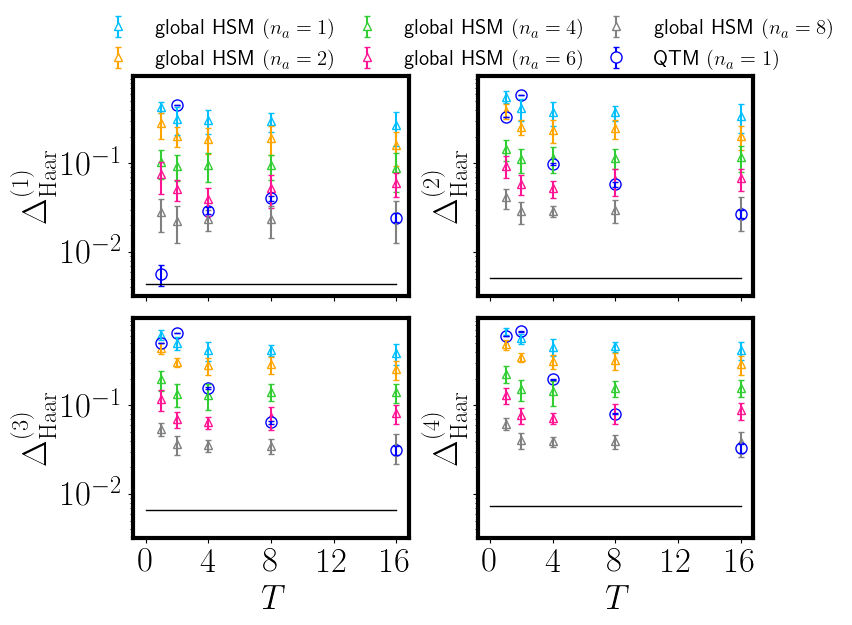

In [14]:
# QTM (one ancilla) vs global HSM
n = 1
na = 1
L = n + na
Ts = [1, 2, 4, 8, 16]
b = 1
nas_hsm = [1, 2, 4, 6, 8]
T = 24
Ndata = int(1e4)

Ks = [1, 2, 3, 4]
path = 'data/QWIT/zero2haar/'
mmt_dist_hsm = np.zeros((len(Ks), len(nas_hsm), 10, len(Ts)))
for i in range(len(Ks)):
    mmt_dist_hsm_eachK = np.load(os.path.join(path, f'haSeq/n{n}/haSeqGlMMTdistK{Ks[i]}_n{n}T{T}.npy'))
    mmt_dist_hsm[i] = np.stack([mmt_dist_hsm_eachK[:, :, Ts[j]] for j in range(len(Ts))], axis=2)
mmt_dist_qtm = np.zeros((len(Ks), 10, len(Ts)))
for i in range(len(Ks)):  
    mmt_dist_qtm_eachK = np.load(os.path.join(path, f'n{n}/mmts/QTMMMTdistK{Ks[i]}_n{n}na{na}L{L}b{b}.npy'))
    for j in range(len(Ts)):
        mmt_dist_qtm[i, :, j] = mmt_dist_qtm_eachK[j, :, Ts[j]]

fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
cl = ['deepskyblue', 'orange', 'limegreen', 'deeppink', 'grey']
for i in range(len(Ks)):
    for j in range(len(nas_hsm)):
        axs[i//2, i%2].errorbar(Ts, np.mean(mmt_dist_hsm[i, j], axis=0), yerr=np.std(mmt_dist_hsm[i, j], axis=0),
            fmt='^', mfc='white', markersize=6, barsabove=True, capsize=2, c=cl[j], 
            label='global HSM ' + fr'$(n_a = {nas_hsm[j]})$')
    axs[i//2, i%2].errorbar(Ts, np.mean(mmt_dist_qtm[i], axis=0), yerr=np.std(mmt_dist_qtm[i], axis=0), fmt='o', 
        mfc='white', markersize=8, barsabove=True, capsize=2, c='b', label='QTM ' + r'$(n_a=1)$')
    mmt_base = traceDist(rho_moment(HaarSampleGeneration(Ndata, n, seed=200), Ks[i]), 
                         haarEnsembleMMT(n, Ks[i]))
    axs[i//2, i%2].plot(mmt_base*np.ones(Ts[-1] + 1), c='k', lw=1)
    axs[i//2, i%2].set_ylabel(fr'$\Delta_{{\rm Haar}}^{{({Ks[i]})}}$')
    axs[1, i%2].set_xlabel(r'$T$')
    axs[i//2, i%2].set_xticks(np.arange(5)*4)
axs[0, 0].set_yscale('log')
axs[0, 0].legend(ncol=3, columnspacing=0.5, fontsize=15, loc='upper left', bbox_to_anchor=(-0.2, 1.35), 
                 framealpha=0)

plt.subplots_adjust(wspace=0.25, hspace=0.1)

Text(0.5, 0, '$T$')

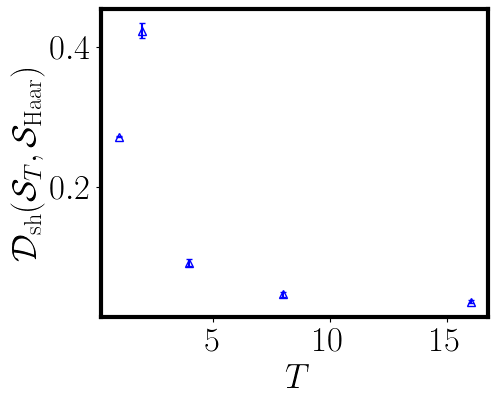

In [28]:
# sinkhorn distances
n = 1
na = 1
L = n + na
Ts = [1, 2, 4, 8, 16]
b = 1
Ndata = int(1e4)

path = f'data/QWIT/zero2haar/n{n}'

sh_dists = np.zeros((len(Ts), 10))
states_haar = HaarSampleGeneration(256, n, seed=12)
for i in range(len(Ts)):
    states = np.load(os.path.join(path, f'QTMstates_n{n}na{na}T{Ts[i]}L{L}b{b}.npy'))[-1]
    idx = np.random.choice(Ndata, 256, replace=False)
    state_samples = states[:, idx]
    for k in range(10):
        sh_dists[i, k] = sinkhornDistance(states_haar, state_samples[k], reg=0.005)

fig, ax = plt.subplots(figsize=(5, 4))
ax.errorbar(Ts, np.mean(sh_dists, axis=1), yerr=np.std(sh_dists, axis=1), fmt='^', 
            mfc='white', markersize=6, barsabove=True, capsize=2, c='b')
ax.set_ylabel(r'$\mathcal{D}_{\rm sh}(\mathcal{S}_T, \mathcal{S}_{\rm Haar})$')
ax.set_xlabel(r'$T$')

c:\Users\Bingzhi\envs\tensorCircuit_tf\lib\site-packages\IPython\core\interactiveshell.py:3526: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


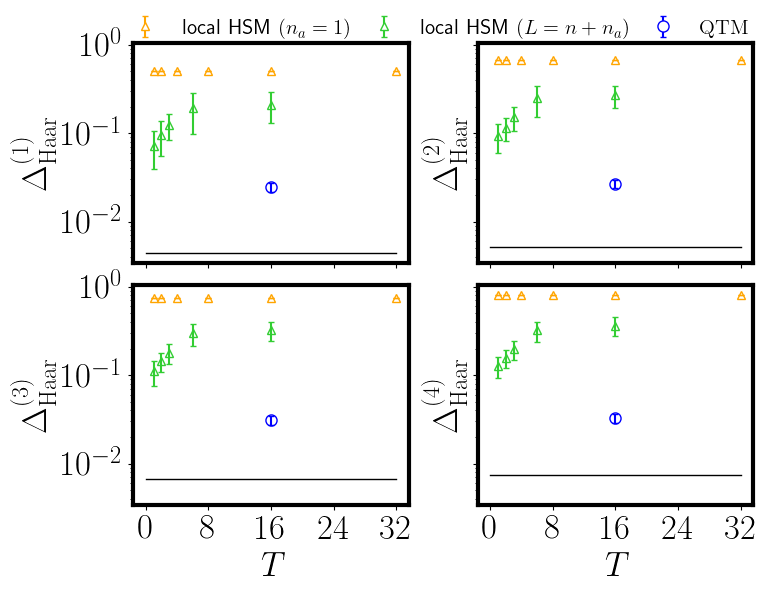

In [146]:
# QTM vs local HSM
n = 1
Ks = [1, 2, 3, 4]
path = 'data/QWIT/zero2haar/'

# QTM
na_tr, T_tr = 1, 16
Ngates = T_tr * (n + na_tr) * (n + na_tr - 1)
b = 1
Ndata = int(1e4)
mmt_dist_qtm = np.zeros((len(Ks), 10))
for i in range(len(Ks)):
    mmt_dist_qtm[i] = np.load(os.path.join(path, 
        f'n{n}/mmts/QTMMMTdistK{Ks[i]}_n{n}na{na_tr}L{n + na_tr}b{b}.npy'))[-1, :, -1]

# local HSM (na = 1)
Ts1 = find_divisors(Ngates//(n + na_tr - 1))
mmt_dist_hsm_lo1 = np.zeros((len(Ks), len(Ts1), 10))
for i in range(len(Ks)):
    mmt_dist_hsm_lo1[i] = np.load(os.path.join(path, 
        f'haSeq/n{n}/haSeqLoMMTdistK{Ks[i]}_n{n}na{na_tr}G{Ngates}.npy'))

# local HSM (L = n + na)
nas = np.array([1, 2, 3, 4, 6])
Ts2 = np.ceil(Ngates/((n + nas) * (n + nas - 1)))
nas, Ts2 = nas[::-1], Ts2[::-1]
mmt_dist_hsm_lo2 = np.zeros((len(Ks), len(Ts2), 10))
for i in range(len(Ks)):
    mmt_dist_hsm_lo2[i] = np.load(os.path.join(path, 
                            f'haSeq/n{n}/haSeqLoMMTdistK{Ks[i]}_n{n}L=n+naG{Ngates}.npy'))

fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
for i in range(len(Ks)):
    axs[i//2, i%2].errorbar(Ts1, np.mean(mmt_dist_hsm_lo1[i], axis=1), 
        yerr=np.std(mmt_dist_hsm_lo1[i], axis=1), c='orange', fmt='^', mfc='white', 
        markersize=6, barsabove=True, capsize=2, label='local HSM '+ fr'$(n_a = {na_tr})$')
    axs[i//2, i%2].errorbar(Ts2, np.mean(mmt_dist_hsm_lo2[i], axis=1), 
        yerr=np.std(mmt_dist_hsm_lo2[i], axis=1), c='limegreen', fmt='^', mfc='white',
        markersize=6, barsabove=True, capsize=2, label='local HSM ' + r'$(L=n+n_a)$')
    axs[i//2, i%2].errorbar(T_tr, np.mean(mmt_dist_qtm[i], axis=0), yerr=np.std(mmt_dist_qtm[i], axis=0), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c='b', label=r'$\rm QTM$')
    mmt_base = traceDist(rho_moment(HaarSampleGeneration(Ndata, n, seed=200), Ks[i]), 
                         haarEnsembleMMT(n, Ks[i]))
    axs[i//2, i%2].plot(mmt_base*np.ones(max(Ts1) + 1), c='k', lw=1)
    axs[i//2, i%2].set_ylabel(fr'$\Delta_{{\rm Haar}}^{{({Ks[i]})}}$')
    axs[1, i%2].set_xlabel(r'$T$')
    axs[i//2, i%2].set_xticks(np.arange(5)*8)
axs[0, 0].set_yscale('log')
axs[0, 0].legend(fontsize=15, ncol=3, columnspacing=0.5, loc='upper left', bbox_to_anchor=(-0.1, 1.2),
                 framealpha=0)

plt.subplots_adjust(wspace=0.25, hspace=0.1)

# 2 qubit result

## scaling of haar ensemble

[    4     8    16    32    64   128   256   512  1024  2048  4096  8192
 16384]
mmt, K=1, fitting result=[-0.50538716 -0.25495267]
fp, K=1, fitting result=[-1.01270224 -0.1946557 ]
mmt, K=2, fitting result=[-0.5013317   0.24426768]
fp, K=2, fitting result=[-1.00633274 -0.06458272]
mmt, K=3, fitting result=[-0.50377673  0.63109147]
fp, K=3, fitting result=[-1.01056015  0.02481528]
mmt, K=4, fitting result=[-0.50682641  0.94805582]
fp, K=4, fitting result=[-1.01824845  0.11388889]


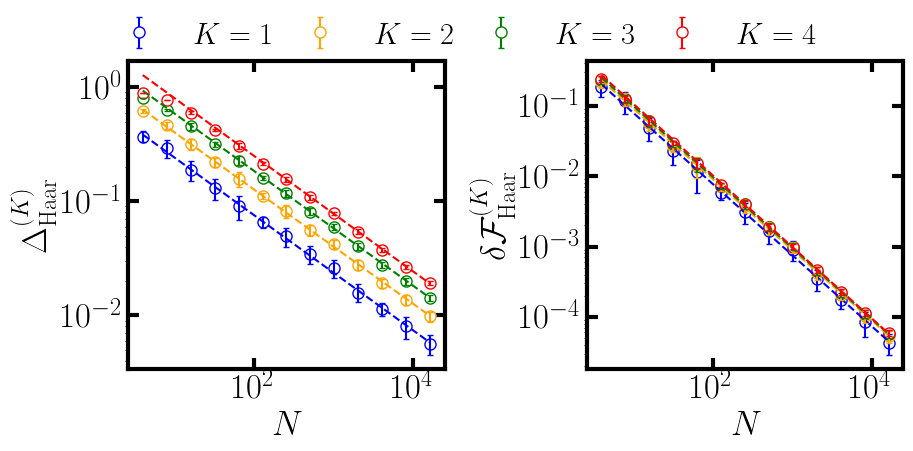

In [210]:
# scaling of moment distance and frame potential with respect to number of samples
Ks = [1, 2, 3, 4]
n = 2
Nlist = 2**np.arange(2, 15)
print(Nlist)
mmts = np.zeros((len(Ks), len(Nlist), 10))
fps = np.zeros((len(Ks), len(Nlist), 10))
for i in range(len(Ks)):
    mmts[i] = np.load(f'data/QWIT/zero2haar/haar/MMTdistK{Ks[i]}_n2.npy')
    fps[i] = np.load(f'data/QWIT/zero2haar/haar/FPK{Ks[i]}_n2.npy')

fps_haar = 1./binom(4 + np.arange(1, 5) - 1, np.arange(1, 5))

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
cl = ['b', 'orange', 'g', 'r']
Ns = np.arange(4, 2**14)
for i in range(4):
    axs[0].errorbar(Nlist, np.mean(mmts[i], axis=1), yerr=np.std(mmts[i], axis=1), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c=cl[i], label=fr'$K={Ks[i]}$')
    res_fit1 = np.polyfit(x=np.log(Nlist[2*i:]), y=np.log(np.mean(mmts[i, 2*i:], axis=1)), deg=1)
    print(f'mmt, K={Ks[i]}, fitting result={res_fit1}')
    axs[0].plot(Ns, np.exp(res_fit1[1])*Ns**res_fit1[0], '--', c=cl[i])

    axs[1].errorbar(Nlist, np.mean(fps[i], axis=1)-fps_haar[i], yerr=np.std(fps[i]-fps_haar[i], axis=1), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c=cl[i], label=fr'$K={Ks[i]}$')
    res_fit2 = np.polyfit(x=np.log(Nlist[2*i:]), y=np.log(np.mean(fps[i, 2*i:]-fps_haar[i], axis=1)), deg=1)
    print(f'fp, K={Ks[i]}, fitting result={res_fit2}')
    axs[1].plot(Ns, np.exp(res_fit2[1])*Ns**res_fit2[0], '--', c=cl[i])
    
axs[0].legend(fontsize=22, loc='lower left', bbox_to_anchor=(-0.15, 0.95), ncols=4, columnspacing=0.5, 
    framealpha=0)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[1].set_yscale('log')
axs[0].set_ylabel(fr'$\Delta_{{\rm Haar}}^{{(K)}}$')
axs[1].set_ylabel(fr'$\delta \mathcal{{F}}_{{\rm Haar}}^{{(K)}}$')
axs[0].set_xlabel(r'$N$')
axs[1].set_xlabel(r'$N$')
for i in range(2):
    axs[i].tick_params(direction='in', length=8, width=3, top='on', right='on')
plt.subplots_adjust(wspace=0.45)
plt.savefig('figures/haar_scalings.pdf', bbox_inches='tight')
plt.show()
plt.close()

## global SRUC

In [51]:
Ks = [1, 2, 3, 4]
n = 2
Ndata = int(1e4)
mmt_base = []
for i in range(len(Ks)):
    mmt = traceDist(rhoMMT(HaarSampleGeneration(Ndata, n, seed=200), Ks[i]), 
                            haarEnsembleMMT(n, Ks[i]))
    mmt_base.append(mmt)
np.array(mmt_base)

c:\Users\Bingzhi\envs\tensorCircuit_tf\lib\site-packages\IPython\core\interactiveshell.py:3526: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


array([0.00792799, 0.01291517, 0.01807931, 0.02409007], dtype=float32)

In [228]:
Ks = [1, 2, 3, 4]
n = 2
Ndata = int(1e4)
fp_base = []
for i in range(len(Ks)):
    rho = rho_moment(HaarSampleGeneration(Ndata, n, seed=200), Ks[i])
    fp_base.append(np.trace(rho @ rho))
np.array(fp_base)

array([0.25009254+0.j, 0.10009212+0.j, 0.05009196+0.j, 0.02866506+0.j],
      dtype=complex64)

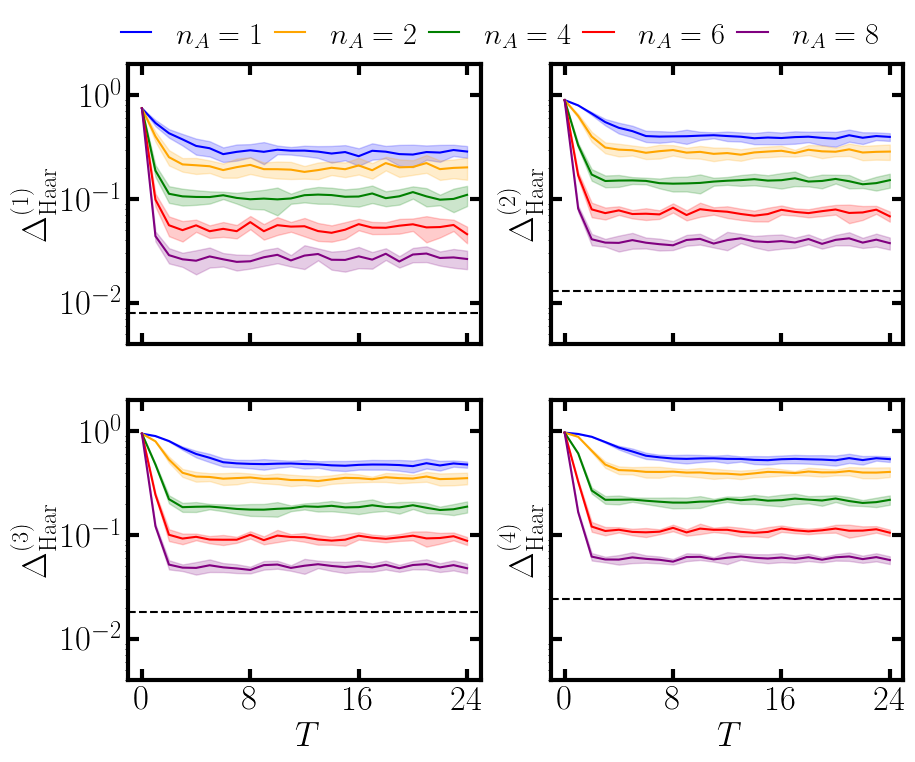

In [236]:
# global SRUC moment distance
n = 2
nas = [1, 2, 4, 6, 8]
T = 24
Ndata = int(1e4)

Ks = [1, 2, 3, 4]
path = 'data/QWIT/zero2haar/SRUC/gSRUC'
mmt_dist = np.zeros((len(Ks), len(nas_hsm), 10, T+1))
for i in range(len(Ks)):
    mmt_dist[i] = np.load(os.path.join(path, f'gSRUCMMTdistK{Ks[i]}_n{n}T{T}.npy'))

mmt_base = np.array([0.00792799, 0.01291517, 0.01807931, 0.02409007])

fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
cl = ['b', 'orange', 'g', 'r', 'purple']
for i in range(len(Ks)):
    for j in range(len(nas)):
        mmt_mean = np.mean(mmt_dist[i, j], axis=0)
        mmt_std = np.std(mmt_dist[i, j], axis=0)
        axs[i//2, i%2].plot(mmt_mean, c=cl[j], label=fr'$n_A = {nas[j]}$')
        axs[i//2, i%2].fill_between(np.arange(T+1), mmt_mean - mmt_std, mmt_mean + mmt_std,
            color=cl[j], alpha=0.2)
    axs[i//2, i%2].hlines(mmt_base[i], xmin=-1, xmax=25, ls='--', color='k')
    axs[i//2, i%2].set_ylabel(fr'$\Delta_{{\rm Haar}}^{{({Ks[i]})}}$')
    axs[1, i%2].set_xlabel(r'$T$')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlim(-1, 25)
axs[0, 0].set_ylim(4e-3, 2)
axs[0, 0].set_xticks(np.arange(4)*8)
axs[0, 0].legend(ncol=5, columnspacing=0.4, loc='upper left', bbox_to_anchor=(-0.1, 1.25), 
    fontsize=22, handlelength=1, framealpha=0)
for i in range(4):
    axs[i//2, i%2].tick_params(direction='in', length=8, width=3, top='on', right='on')
plt.savefig('figures/gSRUCmmt_n2.pdf', bbox_inches='tight')
plt.show()
plt.close()

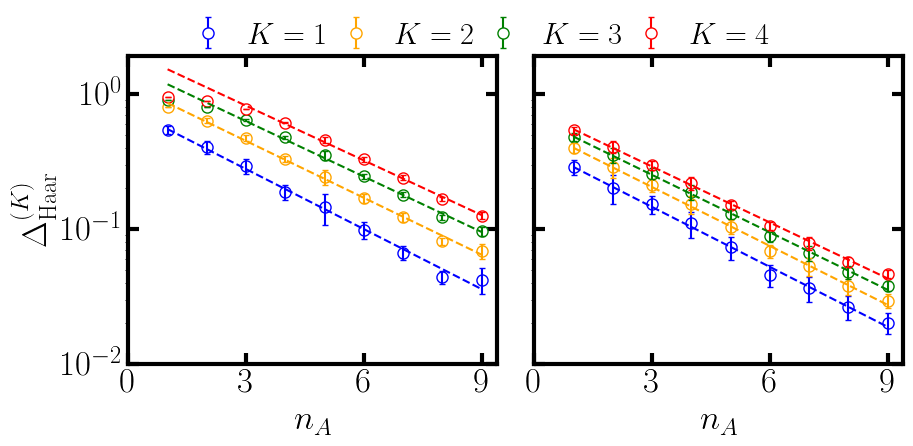

(array([-0.32235542, -0.32984664]), array([0.01165517, 0.00862669]))

In [2]:
# scaling of global SRUC with n_A in T->infty
n = 2
nas = np.arange(1, 10)
T = 24
Ndata = int(1e4)

Ks = [1, 2, 3, 4]
path = f'data/QWIT/zero2haar/SRUC/gSRUC'
mmt_dist1 = np.zeros((len(Ks), len(nas), 10))
mmt_dist2 = np.zeros((len(Ks), len(nas), 10))
for i in range(len(Ks)):
    each = np.load(os.path.join(path, f'gSRUCMMTdistK{Ks[i]}_n{n}T{T}.npy'))
    mmt_dist1[i] = each[:, :, 1]
    mmt_dist2[i] = each[:, :, -1]

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
cl = ['b', 'orange', 'g', 'r']
x = np.arange(1, 10)
fit_res = np.zeros((2, 4))
for i in range(4):
    axs[0].errorbar(nas, np.mean(mmt_dist1[i], axis=1), yerr=np.std(mmt_dist1[i], axis=1), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c=cl[i], label=fr'$K={Ks[i]}$')
    res_fit1 = np.polyfit(nas[max(0, i-1):], np.log(np.mean(mmt_dist1[i], axis=1)[max(0, i-1):]), deg=1)
    fit_res[0, i] = res_fit1[0]
    dist_fit1 = np.exp(res_fit1[0]*x + res_fit1[1])
    axs[0].plot(x, dist_fit1, '--', c=cl[i])

    axs[1].errorbar(nas, np.mean(mmt_dist2[i], axis=1), yerr=np.std(mmt_dist2[i], axis=1), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c=cl[i], label=fr'$K={Ks[i]}$')
    res_fit2 = np.polyfit(nas, np.log(np.mean(mmt_dist2[i], axis=1)), deg=1)
    fit_res[1, i] = res_fit2[0]
    dist_fit2 = np.exp(res_fit2[0]*x + res_fit2[1])
    axs[1].plot(x, dist_fit2, '--', c=cl[i])

axs[0].legend(ncol=5, columnspacing=0.4, loc='upper left', bbox_to_anchor=(0.1, 1.2), 
    fontsize=22, handlelength=1, framealpha=0)
axs[1].set_yscale('log')
axs[0].set_ylabel(r'$\Delta_{{\rm Haar}}^{({K})}$')
axs[0].set_xlabel(r'$n_A$')
axs[1].set_xlabel(r'$n_A$')
axs[0].set_xticks(np.arange(4)*3)
axs[0].set_yticks([1e-2, 1e-1, 1])
for i in range(2):
    axs[i].tick_params(direction='in', length=8, width=3, top='on', right='on')
plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/gSRUCmmtscale_n2.pdf', bbox_inches='tight')
plt.show()
plt.close()

np.mean(fit_res, axis=1), np.std(fit_res, axis=1)

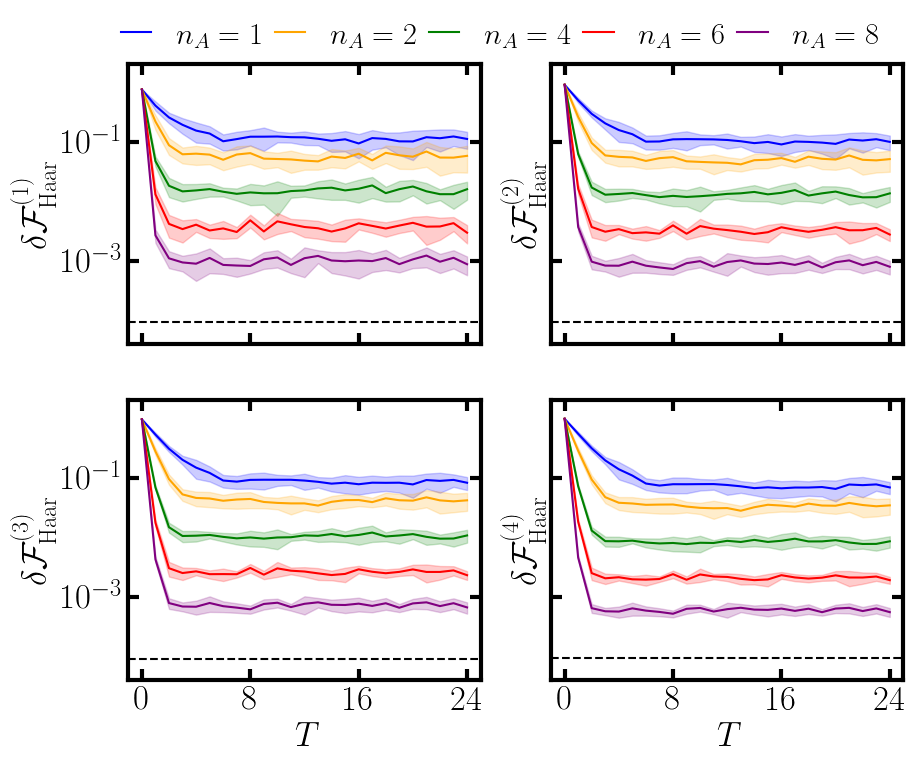

In [257]:
# global SRUC frame potential
n = 2
nas = [1, 2, 4, 6, 8]
T = 24
Ndata = int(1e4)

Ks = [1, 2, 3, 4]
path = f'data/QWIT/zero2haar/SRUC/gSRUC'
fps = np.zeros((len(Ks), len(nas), 10, T+1))
for i in range(len(Ks)):
    fps[i] = np.load(os.path.join(path, f'gSRUCFPK{Ks[i]}_n{n}T{T}.npy'))

fp_base = np.array([0.25009254, 0.10009212, 0.05009196, 0.02866506])
fp_exact = 1./binom(2**n + np.arange(1, 5) - 1, np.arange(1, 5))

fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
cl = ['b', 'orange', 'g', 'r', 'purple']
for i in range(len(Ks)):
    for j in range(len(nas)):
        dfp_mean = np.mean(fps[i, j] - fp_exact[i], axis=0)
        dfp_std = np.std(fps[i, j] - fp_exact[i], axis=0)
        axs[i//2, i%2].plot(dfp_mean , c=cl[j], label=fr'$n_A = {nas[j]}$')
        axs[i//2, i%2].fill_between(np.arange(T+1), dfp_mean - dfp_std, dfp_mean + dfp_std,
            color=cl[j], alpha=0.2)
    axs[i//2, i%2].hlines(fp_base[i] - fp_exact[i], xmin=-1, xmax=25, ls='--', color='k')
    axs[i//2, i%2].set_ylabel(fr'$\delta \mathcal{{F}}_{{\rm Haar}}^{{({Ks[i]})}}$')
    axs[1, i%2].set_xlabel(r'$T$')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlim(-1, 25)
axs[0, 0].set_ylim(4e-5, 2)
axs[0, 0].set_xticks(np.arange(4)*8)
axs[0, 0].legend(ncol=5, columnspacing=0.4, loc='upper left', bbox_to_anchor=(-0.1, 1.25), 
    fontsize=22, handlelength=1, framealpha=0)
for i in range(4):
    axs[i//2, i%2].tick_params(direction='in', length=8, width=3, top='on', right='on')
plt.savefig('figures/gSRUCfp_n2.pdf', bbox_inches='tight')
plt.show()
plt.close()

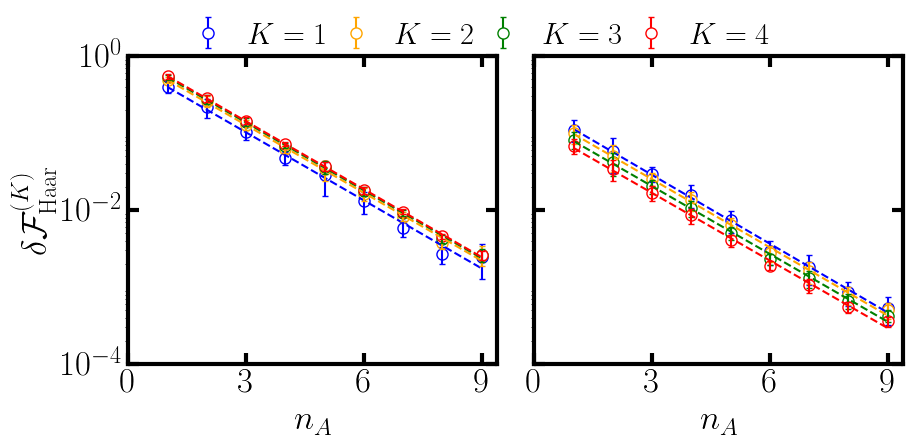

(array([-0.67651543, -0.67824188]), array([0.00084091, 0.00463685]))

In [55]:
# scaling of global SRUC with n_A in T->infty
n = 2
nas = np.arange(1, 10)
T = 24
Ndata = int(1e4)

Ks = [1, 2, 3, 4]
path = f'data/QWIT/zero2haar/SRUC/gSRUC'
fps1 = np.zeros((len(Ks), len(nas), 10))
fps2 = np.zeros((len(Ks), len(nas), 10))
for i in range(len(Ks)):
    each = np.load(os.path.join(path, f'gSRUCFPK{Ks[i]}_n{n}T{T}.npy'))
    fps1[i] = each[:, :, 1]
    fps2[i] = each[:, :, -1]

fp_exact = 1./binom(2**n + np.arange(1, 5) - 1, np.arange(1, 5))

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
cl = ['b', 'orange', 'g', 'r']
x = np.arange(1, 10)
fit_res = np.zeros((2, 4))
for i in range(4):
    axs[0].errorbar(nas, np.mean(fps1[i] - fp_exact[i], axis=1),  yerr=np.std(fps1[i] - fp_exact[i], axis=1), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c=cl[i], label=fr'$K={Ks[i]}$')
    res_fit1 = np.polyfit(nas, np.log(np.mean(fps1[i] - fp_exact[i], axis=1)), deg=1)
    fit_res[0, i] = res_fit1[0]
    axs[0].plot(x, np.exp(res_fit1[0]*x + res_fit1[1]), '--', c=cl[i])

    axs[1].errorbar(nas, np.mean(fps2[i] - fp_exact[i], axis=1), yerr=np.std(fps2[i] - fp_exact[i], axis=1), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c=cl[i], label=fr'$K={Ks[i]}$')
    res_fit2 = np.polyfit(nas, np.log(np.mean(fps2[i] - fp_exact[i], axis=1)), deg=1)
    fit_res[1, i] = res_fit2[0]
    axs[1].plot(x, np.exp(res_fit2[0]*x + res_fit2[1]), '--', c=cl[i])

axs[0].legend(ncol=5, columnspacing=0.4, loc='upper left', bbox_to_anchor=(0.1, 1.2), 
    fontsize=22, handlelength=1, framealpha=0)
axs[1].set_yscale('log')
axs[0].set_ylabel(r'$\delta \mathcal{F}_{{\rm Haar}}^{({K})}$')
axs[0].set_xlabel(r'$n_A$')
axs[1].set_xlabel(r'$n_A$')
axs[0].set_xticks(np.arange(4)*3)
axs[0].set_yticks([1e-4, 1e-2, 1])
for i in range(2):
    axs[i].tick_params(direction='in', length=8, width=3, top='on', right='on')
plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/gSRUCfpscale_n2.pdf', bbox_inches='tight')
plt.show()
plt.close()

np.mean(fit_res, axis=1), np.std(fit_res, axis=1)

## local SRUC

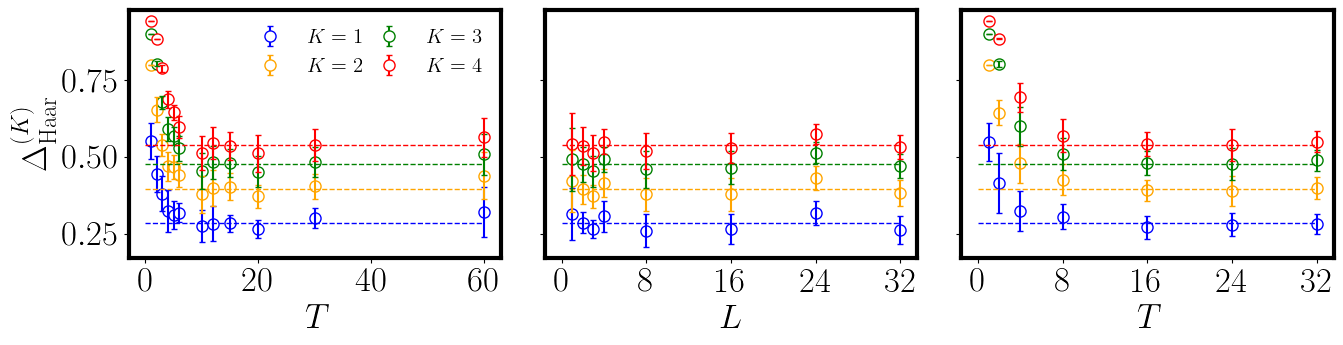

In [114]:
# moment distance
n = 2
na = 1
T = 20
Ngates = T * (n + na) * (n + na - 1)

Ks = [1, 2, 3, 4]
path = f'data/QWIT/zero2haar/SRUC/lSRUC'

Ts = [1, 2, 3, 4, 5, 6, 10, 12, 15, 20, 30, 60]
mmt_dist1 = np.zeros((len(Ks), len(Ts), 10))
for i in range(len(Ks)):
    mmt_dist1[i] = np.load(os.path.join(path, f'lSRUCMMTdistK{Ks[i]}_n{n}na{na}G{Ngates}.npy'))

Ls = [1, 2, 3, 4, 8, 16, 24, 32]
mmt_dist2 = np.zeros((len(Ks), len(Ls), 10))
for i in range(len(Ks)):
    mmt_dist2[i] = np.load(os.path.join(path, f'lSRUCMMTdistK{Ks[i]}_n{n}na{na}T{T}.npy'))

Ts2 = [1, 2, 4, 8, 16, 24, 32]
mmt_dist3 = np.zeros((len(Ks), 10, len(Ts2)))
for i in range(len(Ks)):
    each = np.load(os.path.join(path, f'lSRUCMMTdistK{Ks[i]}_n{n}na{na}T32L{n+na}.npy'))
    mmt_dist3[i] = each[:, Ts2]

mmt_dist_g = [0.28708322, 0.39730368, 0.47843691, 0.53910876]

fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
cl = ['b', 'orange', 'g', 'r']
for i in range(4):
    axs[0].errorbar(Ts, np.mean(mmt_dist1[i], axis=1), yerr=np.std(mmt_dist1[i], axis=1), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c=cl[i], label=fr'$K={Ks[i]}$')
    axs[0].plot(mmt_dist_g[i]*np.ones(61), '--', c=cl[i], lw=1)

    axs[1].errorbar(Ls, np.mean(mmt_dist2[i], axis=1), yerr=np.std(mmt_dist2[i], axis=1), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c=cl[i], label=fr'$K={Ks[i]}$')
    axs[1].plot(mmt_dist_g[i]*np.ones(33), '--', c=cl[i], lw=1)

    axs[2].errorbar(Ts2, np.mean(mmt_dist3[i], axis=0), yerr=np.std(mmt_dist3[i], axis=0), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c=cl[i], label=fr'$K={Ks[i]}$')
    axs[2].plot(mmt_dist_g[i]*np.ones(33), '--', c=cl[i], lw=1)
axs[0].legend(fontsize=15, ncol=2, columnspacing=0.2, framealpha=0)
axs[0].set_xlabel(r'$T$')
axs[0].set_ylabel(r'$\Delta_{{\rm Haar}}^{({K})}$')
axs[1].set_xlabel(r'$L$')
axs[2].set_xlabel(r'$T$')
axs[0].set_xticks(np.arange(4)*20)
axs[1].set_xticks(np.arange(5)*8)
axs[2].set_xticks(np.arange(5)*8)

plt.tight_layout()
plt.savefig('figures/lSRUCmmt_n2.pdf', bbox_inches='tight')
plt.show()
plt.close()

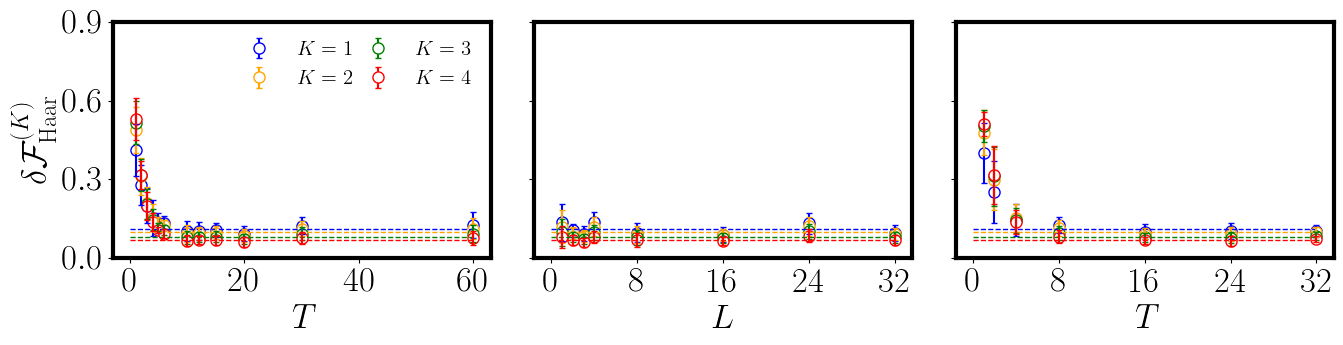

In [120]:
n = 2
na = 1
T = 20
Ngates = T_tr * (n + na) * (n + na - 1)

Ks = [1, 2, 3, 4]
path = f'data/QWIT/zero2haar/SRUC/lSRUC'

Ts = [1, 2, 3, 4, 5, 6, 10, 12, 15, 20, 30, 60]
fps1 = np.zeros((len(Ks), len(Ts), 10))
for i in range(len(Ks)):
    fps1[i] = np.load(os.path.join(path, f'lSRUCFPK{Ks[i]}_n{n}na{na}G{Ngates}.npy'))

Ls = [1, 2, 3, 4, 8, 16, 24, 32]
fps2 = np.zeros((len(Ks), len(Ls), 10))
for i in range(len(Ks)):
    fps2[i] = np.load(os.path.join(path, f'lSRUCFPK{Ks[i]}_n{n}na{na}T{T}.npy'))

Ts2 = [1, 2, 4, 8, 16, 24, 32]
fps3 = np.zeros((len(Ks), 10, len(Ts2)))
for i in range(len(Ks)):
    each = np.load(os.path.join(path, f'lSRUCFPK{Ks[i]}_n{n}na{na}T32L{n+na}.npy'))
    fps3[i] = each[:, Ts2]

fp_exact = 1./binom(2**n + np.arange(1, 5) - 1, np.arange(1, 5))
dfp_g = [0.11085295379161834, 0.09890689849853515, 0.08197444528341294, 0.06839733027986118]

fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
cl = ['b', 'orange', 'g', 'r']
for i in range(4):
    axs[0].errorbar(Ts, np.mean(fps1[i]-fp_exact[i], axis=1), yerr=np.std(fps1[i]-fp_exact[i], axis=1), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c=cl[i], label=fr'$K={Ks[i]}$')
    axs[0].plot(dfp_g[i]*np.ones(61), '--', c=cl[i], lw=1)

    axs[1].errorbar(Ls, np.mean(fps2[i]-fp_exact[i], axis=1), yerr=np.std(fps2[i]-fp_exact[i], axis=1), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c=cl[i], label=fr'$K={Ks[i]}$')
    axs[1].plot(dfp_g[i]*np.ones(33), '--', c=cl[i], lw=1)

    axs[2].errorbar(Ts2, np.mean(fps3[i]-fp_exact[i], axis=0), yerr=np.std(fps3[i]-fp_exact[i], axis=0), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c=cl[i], label=fr'$K={Ks[i]}$')
    axs[2].plot(dfp_g[i]*np.ones(33), '--', c=cl[i], lw=1)
axs[0].legend(fontsize=15, ncol=2, columnspacing=0.2, framealpha=0)
axs[0].set_ylim(0, 0.7)
axs[0].set_xlabel(r'$T$')
axs[0].set_ylabel(r'$\delta \mathcal{F}_{{\rm Haar}}^{({K})}$')
axs[1].set_xlabel(r'$L$')
axs[2].set_xlabel(r'$T$')
axs[0].set_yticks([0, 0.3, 0.6, 0.9])
axs[0].set_xticks(np.arange(4)*20)
axs[1].set_xticks(np.arange(5)*8)
axs[2].set_xticks(np.arange(5)*8)

plt.tight_layout()
plt.savefig('figures/lSRUCfp_n2.pdf', bbox_inches='tight')
plt.show()
plt.close()

## QTM training results

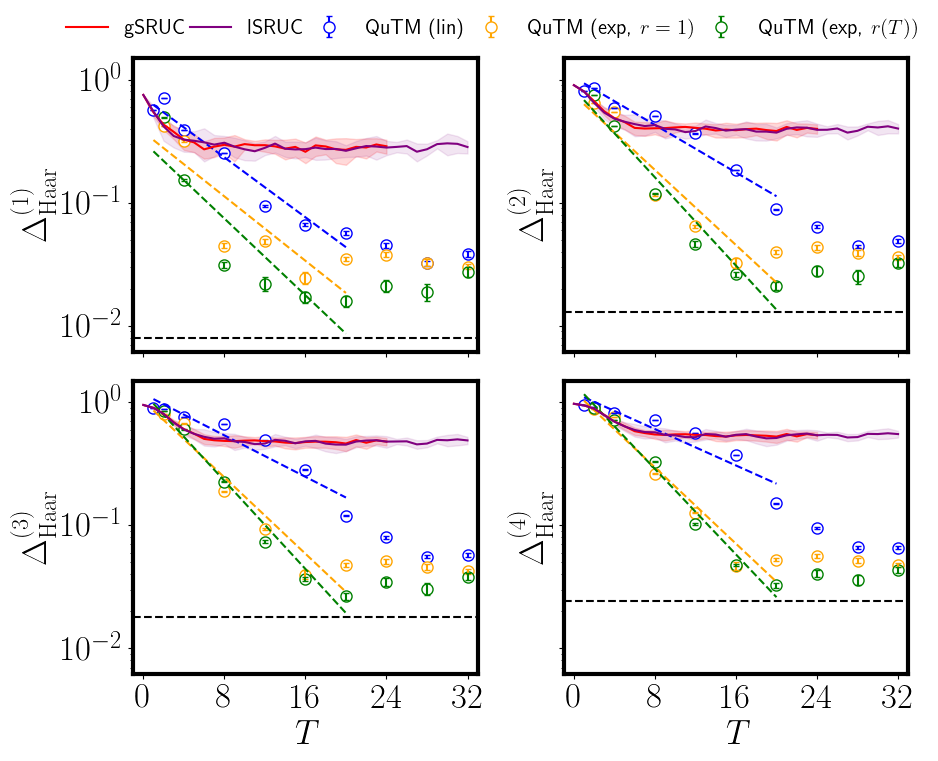

(array([[-0.14005338, -0.11112898, -0.09690199, -0.08500537],
        [-0.15049009, -0.17557926, -0.17855813, -0.17828507],
        [-0.17944261, -0.20628972, -0.20609861, -0.19975284]]),
 array([-0.10827243, -0.17072814, -0.19789595]),
 array([0.0205477 , 0.01174232, 0.01097398]))

In [141]:
# QTM results (moment distance)
n = 2
Ks = [1, 2, 3, 4]
Ts = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
Ndata = int(1e4)
path = 'data/QWIT/zero2haar/'

# linear interpolation
mmt_dist_lin = np.zeros((len(Ks), 10, len(Ts)))
for i in range(len(Ks)):
    each = np.load(os.path.join(path, f'n{n}/mmts/QTMMMTdistK{Ks[i]}_n{n}na1L{n+1}_lin.npy'))
    for j in range(len(Ts)):
        mmt_dist_lin[i, :, j] = each[j, :, Ts[j]]

# exponential interpolation
mmt_dist_exp1 = np.zeros((len(Ks), 10, len(Ts)-1))
for i in range(len(Ks)):
    each = np.load(os.path.join(path, f'n{n}/mmts/QTMMMTdistK{Ks[i]}_n{n}na1L{n+1}_r1.npy'))
    for j in range(len(Ts)-1):
        mmt_dist_exp1[i, :, j] = each[j, :, Ts[j+1]]

mmt_dist_exp2 = np.zeros((len(Ks), 10, len(Ts)-1))
for i in range(len(Ks)):
    each = np.load(os.path.join(path, f'n{n}/mmts/QTMMMTdistK{Ks[i]}_n{n}na1L{n+1}_exp.npy'))
    for j in range(len(Ts)-1):
        mmt_dist_exp2[i, :, j] = each[j, :, Ts[j+1]]

# global HSM
mmt_dist_g = np.zeros((len(Ks), 10, 25))
for i in range(len(Ks)):
    mmt_dist_g[i] = np.load(os.path.join(path, f'SRUC/gSRUC/gSRUCMMTdistK{Ks[i]}_n{n}T24.npy'))[0]

# local HSM
mmt_dist_l = np.zeros((len(Ks), 10, 33))
for i in range(len(Ks)):
    mmt_dist_l[i] = np.load(os.path.join(path, f'SRUC/lSRUC/lSRUCMMTdistK{Ks[i]}_n{n}na1T32L3.npy'))

mmt_base = [0.007927993, 0.012915168, 0.018079314, 0.024090067]

fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
res_fit = np.zeros((3, 4))
for i in range(len(Ks)):
    axs[i//2, i%2].errorbar(Ts, np.mean(mmt_dist_lin[i], axis=0), 
        yerr=np.std(mmt_dist_lin[i], axis=0), fmt='o', mfc='white', markersize=8, 
        barsabove=True, capsize=2, c='b', label='QuTM (lin)')
    axs[i//2, i%2].errorbar(Ts[1:], np.mean(mmt_dist_exp1[i], axis=0), 
        yerr=np.std(mmt_dist_exp1[i], axis=0), fmt='o', mfc='white', markersize=8, 
        barsabove=True, capsize=2, c='orange', label='QuTM (exp, ' + r'$r=1)$')
    axs[i//2, i%2].errorbar(Ts[1:], np.mean(mmt_dist_exp2[i], axis=0), 
        yerr=np.std(mmt_dist_exp2[i], axis=0), fmt='o', mfc='white', markersize=8, 
        barsabove=True, capsize=2, c='g', label='QuTM (exp, ' + r'$r(T))$')
    
    ps1 = np.polyfit(Ts[:7], np.log(np.mean(mmt_dist_lin[i], axis=0)[:7]), deg=1)
    ps2 = np.polyfit(Ts[1:7], np.log(np.mean(mmt_dist_exp1[i], axis=0)[:6]), deg=1)
    ps3 = np.polyfit(Ts[1:7], np.log(np.mean(mmt_dist_exp2[i], axis=0)[:6]), deg=1)
    res_fit[0, i] = ps1[0]
    res_fit[1, i] = ps2[0]
    res_fit[2, i] = ps3[0]
    axs[i//2, i%2].plot(Ts[:7], np.exp(ps1[0]*np.array(Ts[:7])+ps1[1]), '--', c='b')
    axs[i//2, i%2].plot(Ts[:7], np.exp(ps2[0]*np.array(Ts[:7])+ps2[1]), '--', c='orange')
    axs[i//2, i%2].plot(Ts[:7], np.exp(ps3[0]*np.array(Ts[:7])+ps3[1]), '--', c='g')
    
    axs[i//2, i%2].plot(np.arange(25), np.mean(mmt_dist_g[i], axis=0), c='r', label='gSRUC')
    axs[i//2, i%2].fill_between(np.arange(25), np.mean(mmt_dist_g[i], axis=0) - np.std(mmt_dist_g[i], axis=0),
        np.mean(mmt_dist_g[i], axis=0) + np.std(mmt_dist_g[i], axis=0), color='r', alpha=0.15)
    axs[i//2, i%2].plot(np.arange(33), np.mean(mmt_dist_l[i], axis=0), c='purple', label='lSRUC')
    axs[i//2, i%2].fill_between(np.arange(33), np.mean(mmt_dist_l[i], axis=0) - np.std(mmt_dist_l[i], axis=0),
        np.mean(mmt_dist_l[i], axis=0) + np.std(mmt_dist_l[i], axis=0), color='purple', alpha=0.1)
    
    axs[i//2, i%2].hlines(mmt_base[i], xmin=-1, xmax=33, ls='--', color='k')

    axs[i//2, i%2].set_ylabel(fr'$\Delta_{{\rm Haar}}^{{({Ks[i]})}}$')
    axs[1, i%2].set_xlabel(r'$T$')
    axs[i//2, i%2].set_xticks(np.arange(5)*8)
axs[0, 0].set_xlim(-1, 33)
axs[0, 0].set_yscale('log')
axs[0, 0].legend(ncol=5, columnspacing=0.2, fontsize=15, loc='upper left', bbox_to_anchor=(-0.25, 1.2), 
                 framealpha=0)
plt.subplots_adjust(wspace=0.25, hspace=0.1)
plt.savefig('figures/QTM_mmt.pdf', bbox_inches='tight')
plt.show()
plt.close()

res_fit, np.mean(res_fit, axis=1), np.std(res_fit, axis=1)

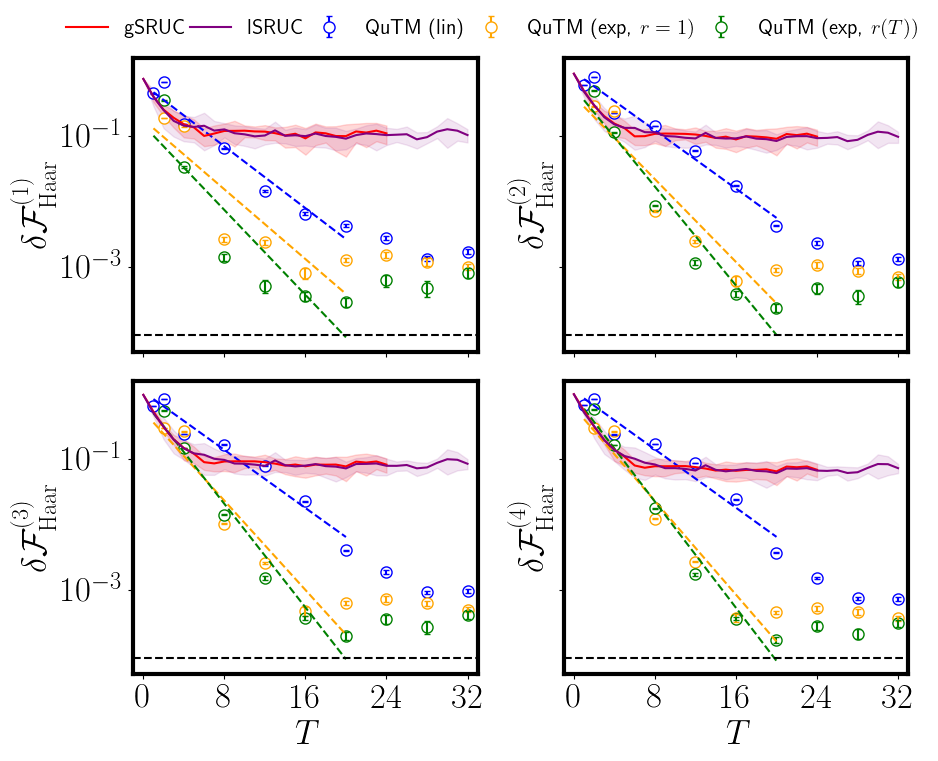

(array([[-0.27146085, -0.25630277, -0.25485322, -0.25592358],
        [-0.30599986, -0.36338029, -0.39185642, -0.41095495],
        [-0.37259616, -0.43382452, -0.45470088, -0.46602817]]),
 array([-0.2596351 , -0.36804788, -0.43178743]),
 array([0.00684826, 0.03962198, 0.03607357]))

In [143]:
# QTM results (frame potential)
n = 2
Ks = [1, 2, 3, 4]
Ts = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
Ndata = int(1e4)
path = 'data/QWIT/zero2haar/'

fp_exact = 1./binom(2**n + np.arange(1, 5) - 1, np.arange(1, 5))

# linear interpolation
fp_lin = np.zeros((len(Ks), 10, len(Ts)))
for i in range(len(Ks)):
    each = np.load(os.path.join(path, f'n{n}/mmts/QTMFPK{Ks[i]}_n{n}na1L{n+1}_lin.npy'))
    for j in range(len(Ts)):
        fp_lin[i, :, j] = each[j, :, Ts[j]] - fp_exact[i]

# exponential interpolation
fp_exp1 = np.zeros((len(Ks), 10, len(Ts)-1))
for i in range(len(Ks)):
    each = np.load(os.path.join(path, f'n{n}/mmts/QTMFPK{Ks[i]}_n{n}na1L{n+1}_r1.npy'))
    for j in range(len(Ts)-1):
        fp_exp1[i, :, j] = each[j, :, Ts[j+1]] - fp_exact[i]

fp_exp2 = np.zeros((len(Ks), 10, len(Ts)-1))
for i in range(len(Ks)):
    each = np.load(os.path.join(path, f'n{n}/mmts/QTMFPK{Ks[i]}_n{n}na1L{n+1}_exp.npy'))
    for j in range(len(Ts)-1):
        fp_exp2[i, :, j] = each[j, :, Ts[j+1]] - fp_exact[i]

# global HSM
fp_g = np.zeros((len(Ks), 10, 25))
for i in range(len(Ks)):
    each = np.load(os.path.join(path, f'SRUC/gSRUC/gSRUCFPK{Ks[i]}_n{n}T24.npy'))[0]
    fp_g[i] = each - fp_exact[i]

# local HSM
fp_l = np.zeros((len(Ks), 10, 33))
for i in range(len(Ks)):
    each = np.load(os.path.join(path, f'SRUC/lSRUC/lSRUCFPK{Ks[i]}_n{n}na1T32L3.npy'))
    fp_l[i] = each - fp_exact[i]

fp_base = np.array([0.25009254, 0.10009212, 0.05009196, 0.02866506])


fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
res_fit = np.zeros((3, 4))
for i in range(len(Ks)):
    axs[i//2, i%2].errorbar(Ts, np.mean(fp_lin[i], axis=0), yerr=np.std(fp_lin[i], axis=0), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c='b', label='QuTM (lin)')
    axs[i//2, i%2].errorbar(Ts[1:], np.mean(fp_exp1[i], axis=0), yerr=np.std(fp_exp1[i], axis=0), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c='orange', label='QuTM (exp, ' + r'$r=1)$')
    axs[i//2, i%2].errorbar(Ts[1:], np.mean(fp_exp2[i], axis=0), yerr=np.std(fp_exp2[i], axis=0), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c='g', label='QuTM (exp, ' + r'$r(T))$')
    
    ps1 = np.polyfit(Ts[:7], np.log(np.mean(fp_lin[i], axis=0)[:7]), deg=1)
    ps2 = np.polyfit(Ts[1:7], np.log(np.mean(fp_exp1[i], axis=0)[:6]), deg=1)
    ps3 = np.polyfit(Ts[1:7], np.log(np.mean(fp_exp2[i], axis=0)[:6]), deg=1)
    res_fit[0, i] = ps1[0]
    res_fit[1, i] = ps2[0]
    res_fit[2, i] = ps3[0]
    axs[i//2, i%2].plot(Ts[:7], np.exp(ps1[0]*np.array(Ts[:7])+ps1[1]), '--', c='b')
    axs[i//2, i%2].plot(Ts[:7], np.exp(ps2[0]*np.array(Ts[:7])+ps2[1]), '--', c='orange')
    axs[i//2, i%2].plot(Ts[:7], np.exp(ps3[0]*np.array(Ts[:7])+ps3[1]), '--', c='g')

    axs[i//2, i%2].plot(np.arange(25), np.mean(fp_g[i], axis=0), c='r', label='gSRUC')
    axs[i//2, i%2].fill_between(np.arange(25), np.mean(fp_g[i], axis=0) - np.std(fp_g[i], axis=0),
        np.mean(fp_g[i], axis=0) + np.std(fp_g[i], axis=0), color='r', alpha=0.15)
    axs[i//2, i%2].plot(np.arange(33), np.mean(fp_l[i], axis=0), c='purple', label='lSRUC')
    axs[i//2, i%2].fill_between(np.arange(33), np.mean(fp_l[i], axis=0) - np.std(fp_l[i], axis=0),
        np.mean(fp_l[i], axis=0) + np.std(fp_l[i], axis=0), color='purple', alpha=0.1)
    
    axs[i//2, i%2].hlines(fp_base[i] - fp_exact[i], xmin=-1, xmax=33, ls='--', color='k')

    axs[i//2, i%2].set_ylabel(fr'$\delta \mathcal{{F}}_{{\rm Haar}}^{{({Ks[i]})}}$')
    axs[1, i%2].set_xlabel(r'$T$')
    axs[i//2, i%2].set_xticks(np.arange(5)*8)
axs[0, 0].set_xlim(-1, 33)
axs[0, 0].set_yscale('log')
axs[0, 0].legend(ncol=5, columnspacing=0.2, fontsize=15, loc='upper left', bbox_to_anchor=(-0.25, 1.2), 
                 framealpha=0)
plt.subplots_adjust(wspace=0.25, hspace=0.1)
plt.savefig('figures/QTM_fp.pdf', bbox_inches='tight')
plt.show()
plt.close()

res_fit, np.mean(res_fit, axis=1), np.std(res_fit, axis=1)

## QTM + average state training

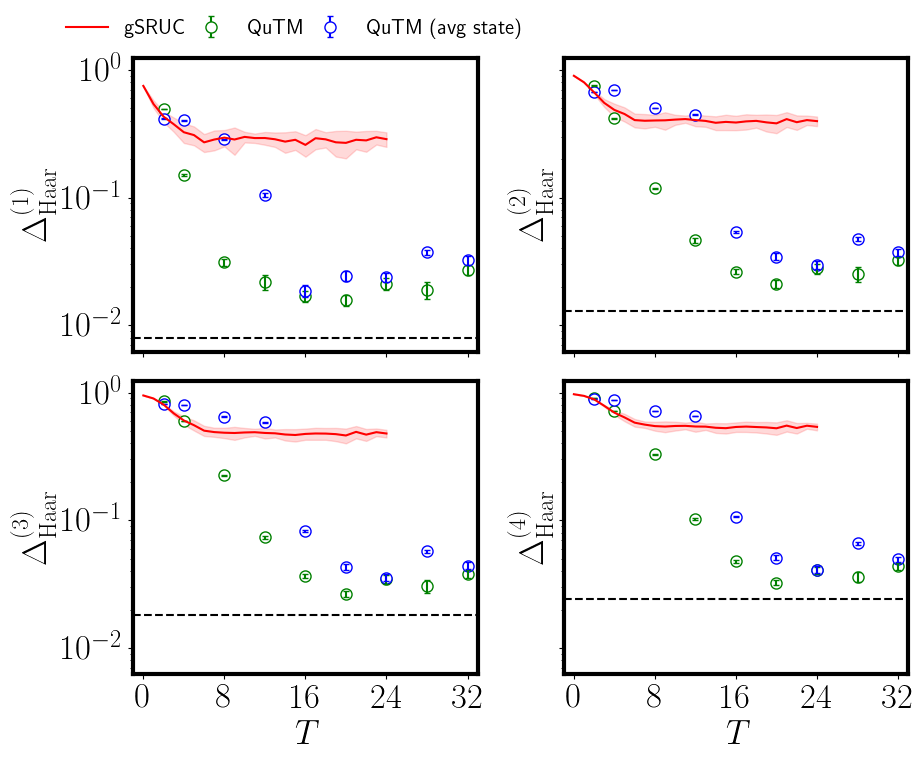

In [26]:
# QTM results (moment distance)
n = 2
Ks = [1, 2, 3, 4]
Ts = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
Ndata = int(1e4)
path = 'data/QWIT/zero2haar/'

mmt_dist_exp = np.zeros((len(Ks), 10, len(Ts)-1))
for i in range(len(Ks)):
    each = np.load(os.path.join(path, f'n{n}/mmts/QTMMMTdistK{Ks[i]}_n{n}na1L{n+1}_exp.npy'))
    for j in range(len(Ts)-1):
        mmt_dist_exp[i, :, j] = each[j, :, Ts[j+1]]

mmt_dist_avg = np.zeros((len(Ks), 10, len(Ts)-1))
for i in range(len(Ks)):
    each = np.load(os.path.join(path, f'n{n}/mmts/HaarAvgMMTdistK{Ks[i]}_n{n}na1L{n+1}_exp.npy'))
    for j in range(len(Ts)-1):
        mmt_dist_avg[i, :, j] = each[j, :, Ts[j+1]]

# global HSM
mmt_dist_g = np.zeros((len(Ks), 10, 25))
for i in range(len(Ks)):
    mmt_dist_g[i] = np.load(os.path.join(path, f'SRUC/gSRUC/gSRUCMMTdistK{Ks[i]}_n{n}T24.npy'))[0]


mmt_base = [0.007927993, 0.012915168, 0.018079314, 0.024090067]

fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
for i in range(len(Ks)):
    axs[i//2, i%2].errorbar(Ts[1:], np.mean(mmt_dist_exp[i], axis=0), 
        yerr=np.std(mmt_dist_exp[i], axis=0), fmt='o', mfc='white', markersize=8, 
        barsabove=True, capsize=2, c='g', label='QuTM')
    axs[i//2, i%2].errorbar(Ts[1:], np.mean(mmt_dist_avg[i], axis=0), 
        yerr=np.std(mmt_dist_avg[i], axis=0), fmt='o', mfc='white', markersize=8, 
        barsabove=True, capsize=2, c='b', label='QuTM (avg state)')
    
    axs[i//2, i%2].plot(np.arange(25), np.mean(mmt_dist_g[i], axis=0), c='r', label='gSRUC')
    axs[i//2, i%2].fill_between(np.arange(25), np.mean(mmt_dist_g[i], axis=0) - np.std(mmt_dist_g[i], axis=0),
        np.mean(mmt_dist_g[i], axis=0) + np.std(mmt_dist_g[i], axis=0), color='r', alpha=0.15)
    
    axs[i//2, i%2].hlines(mmt_base[i], xmin=-1, xmax=33, ls='--', color='k')

    axs[i//2, i%2].set_ylabel(fr'$\Delta_{{\rm Haar}}^{{({Ks[i]})}}$')
    axs[1, i%2].set_xlabel(r'$T$')
    axs[i//2, i%2].set_xticks(np.arange(5)*8)
axs[0, 0].set_xlim(-1, 33)
axs[0, 0].set_yscale('log')
axs[0, 0].legend(ncol=5, columnspacing=0.2, fontsize=15, loc='upper left', bbox_to_anchor=(-0.25, 1.2), 
                 framealpha=0)
plt.subplots_adjust(wspace=0.25, hspace=0.1)